In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from typing import List, Optional, Tuple
from matplotlib.colors import Colormap
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from flyvis import connectome_file
from flyvis.connectome import ConnectomeView, ConnectomeFromAvgFilters
from flyvis.analysis.visualization import plots
from typing import List, Optional, Tuple
from matplotlib.colors import Colormap
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
import pandas as pd

c:\Users\madis\Documents\Perturbations\fly_wire_perturbations\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


DEGENERACY LANDSCAPE ANALYSIS
FlyVis Motion Detection Circuit

[1/7] Loading data...
Loaded original network: 8 cell types
Found 805 perturbation files
Loaded 805 perturbations successfully

[2/7] Computing baseline metrics...
Baseline T4 mean correlation: 0.7626
Baseline T5 mean correlation: 0.8988

[3/7] Computing sensitivity for all perturbations...

Top 10 most sensitive perturbations (T4):
    perturbation source  target  T4_mean_corr  T4_delta  T4_sensitivity
295       R8_Mi1     R8     Mi1      0.000000 -0.762569        0.762569
210      Mi4_Mi9    Mi4     Mi9      0.513766 -0.248803        0.248803
212      Mi4_T4a    Mi4     T4a      0.540211 -0.222359        0.222359
240      Mi9_Mi4    Mi9     Mi4      0.545299 -0.217270        0.217270
185      Mi1_T4a    Mi1     T4a      0.545374 -0.217196        0.217196
525   Tm3_T4d(1)    Tm3  T4d(1)      0.547543 -0.215026        0.215026
526      Tm3_T4d    Tm3     T4d      0.547543 -0.215026        0.215026
517    Tm3_T3(1)    Tm3   

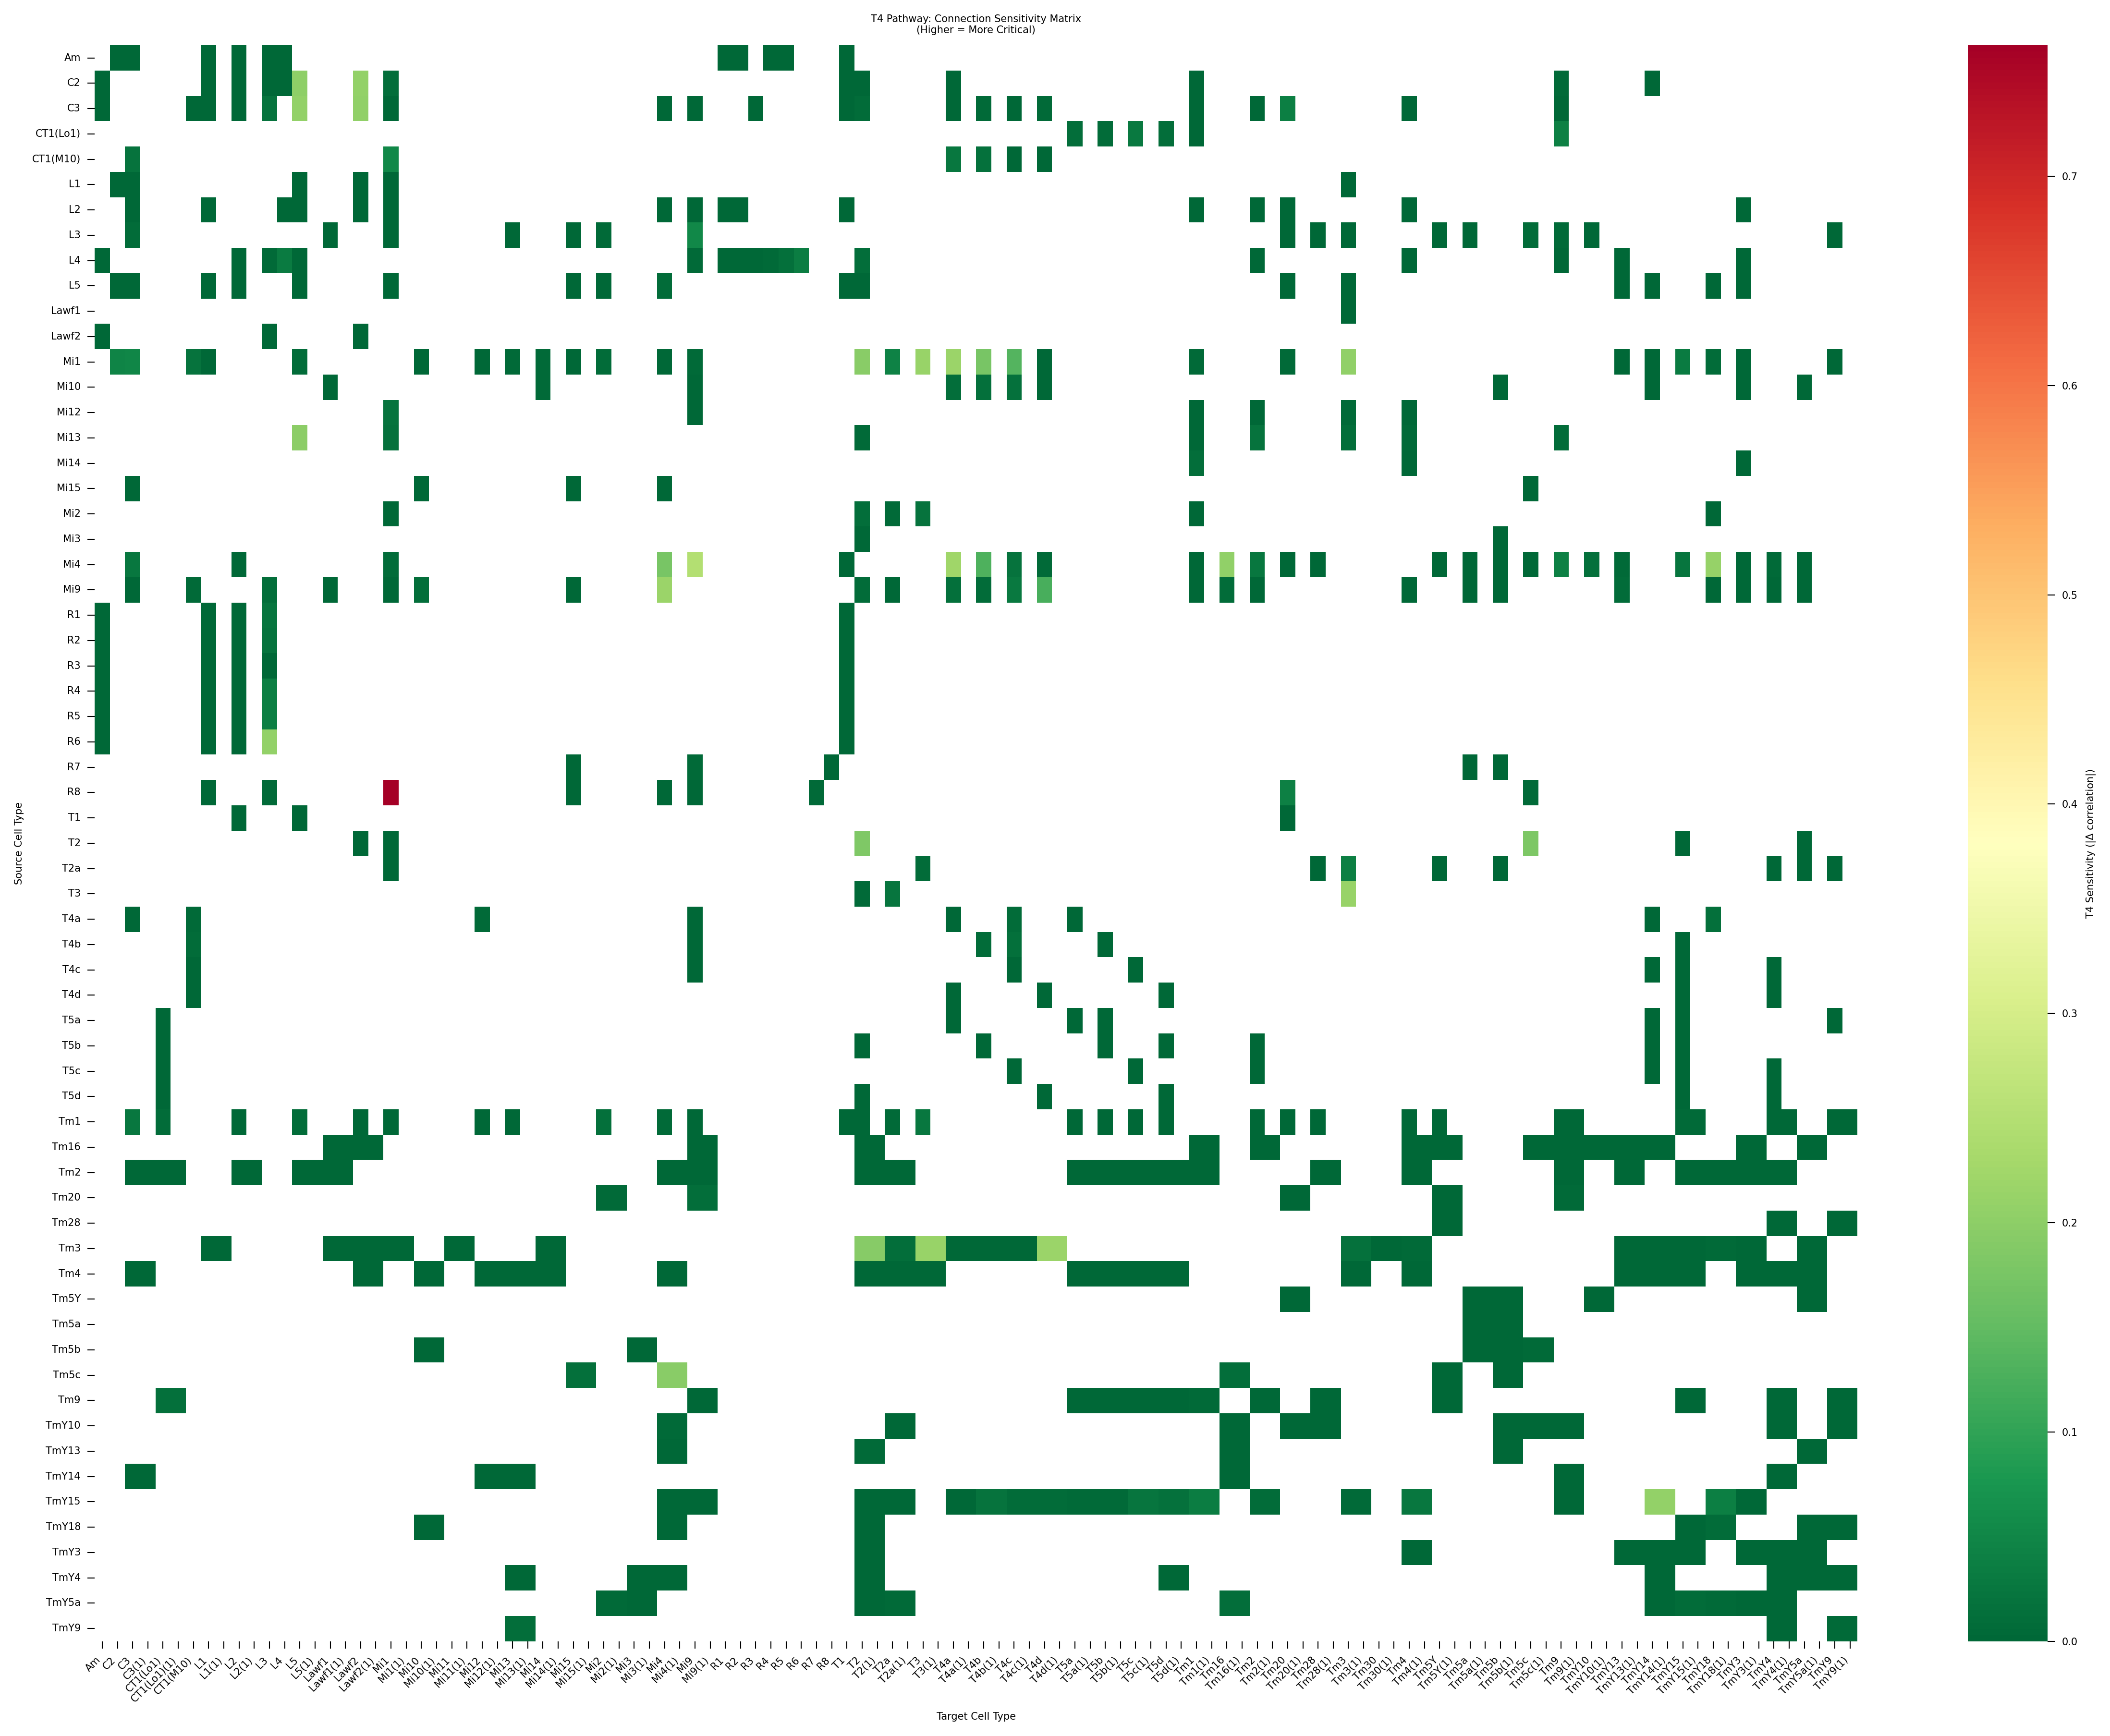

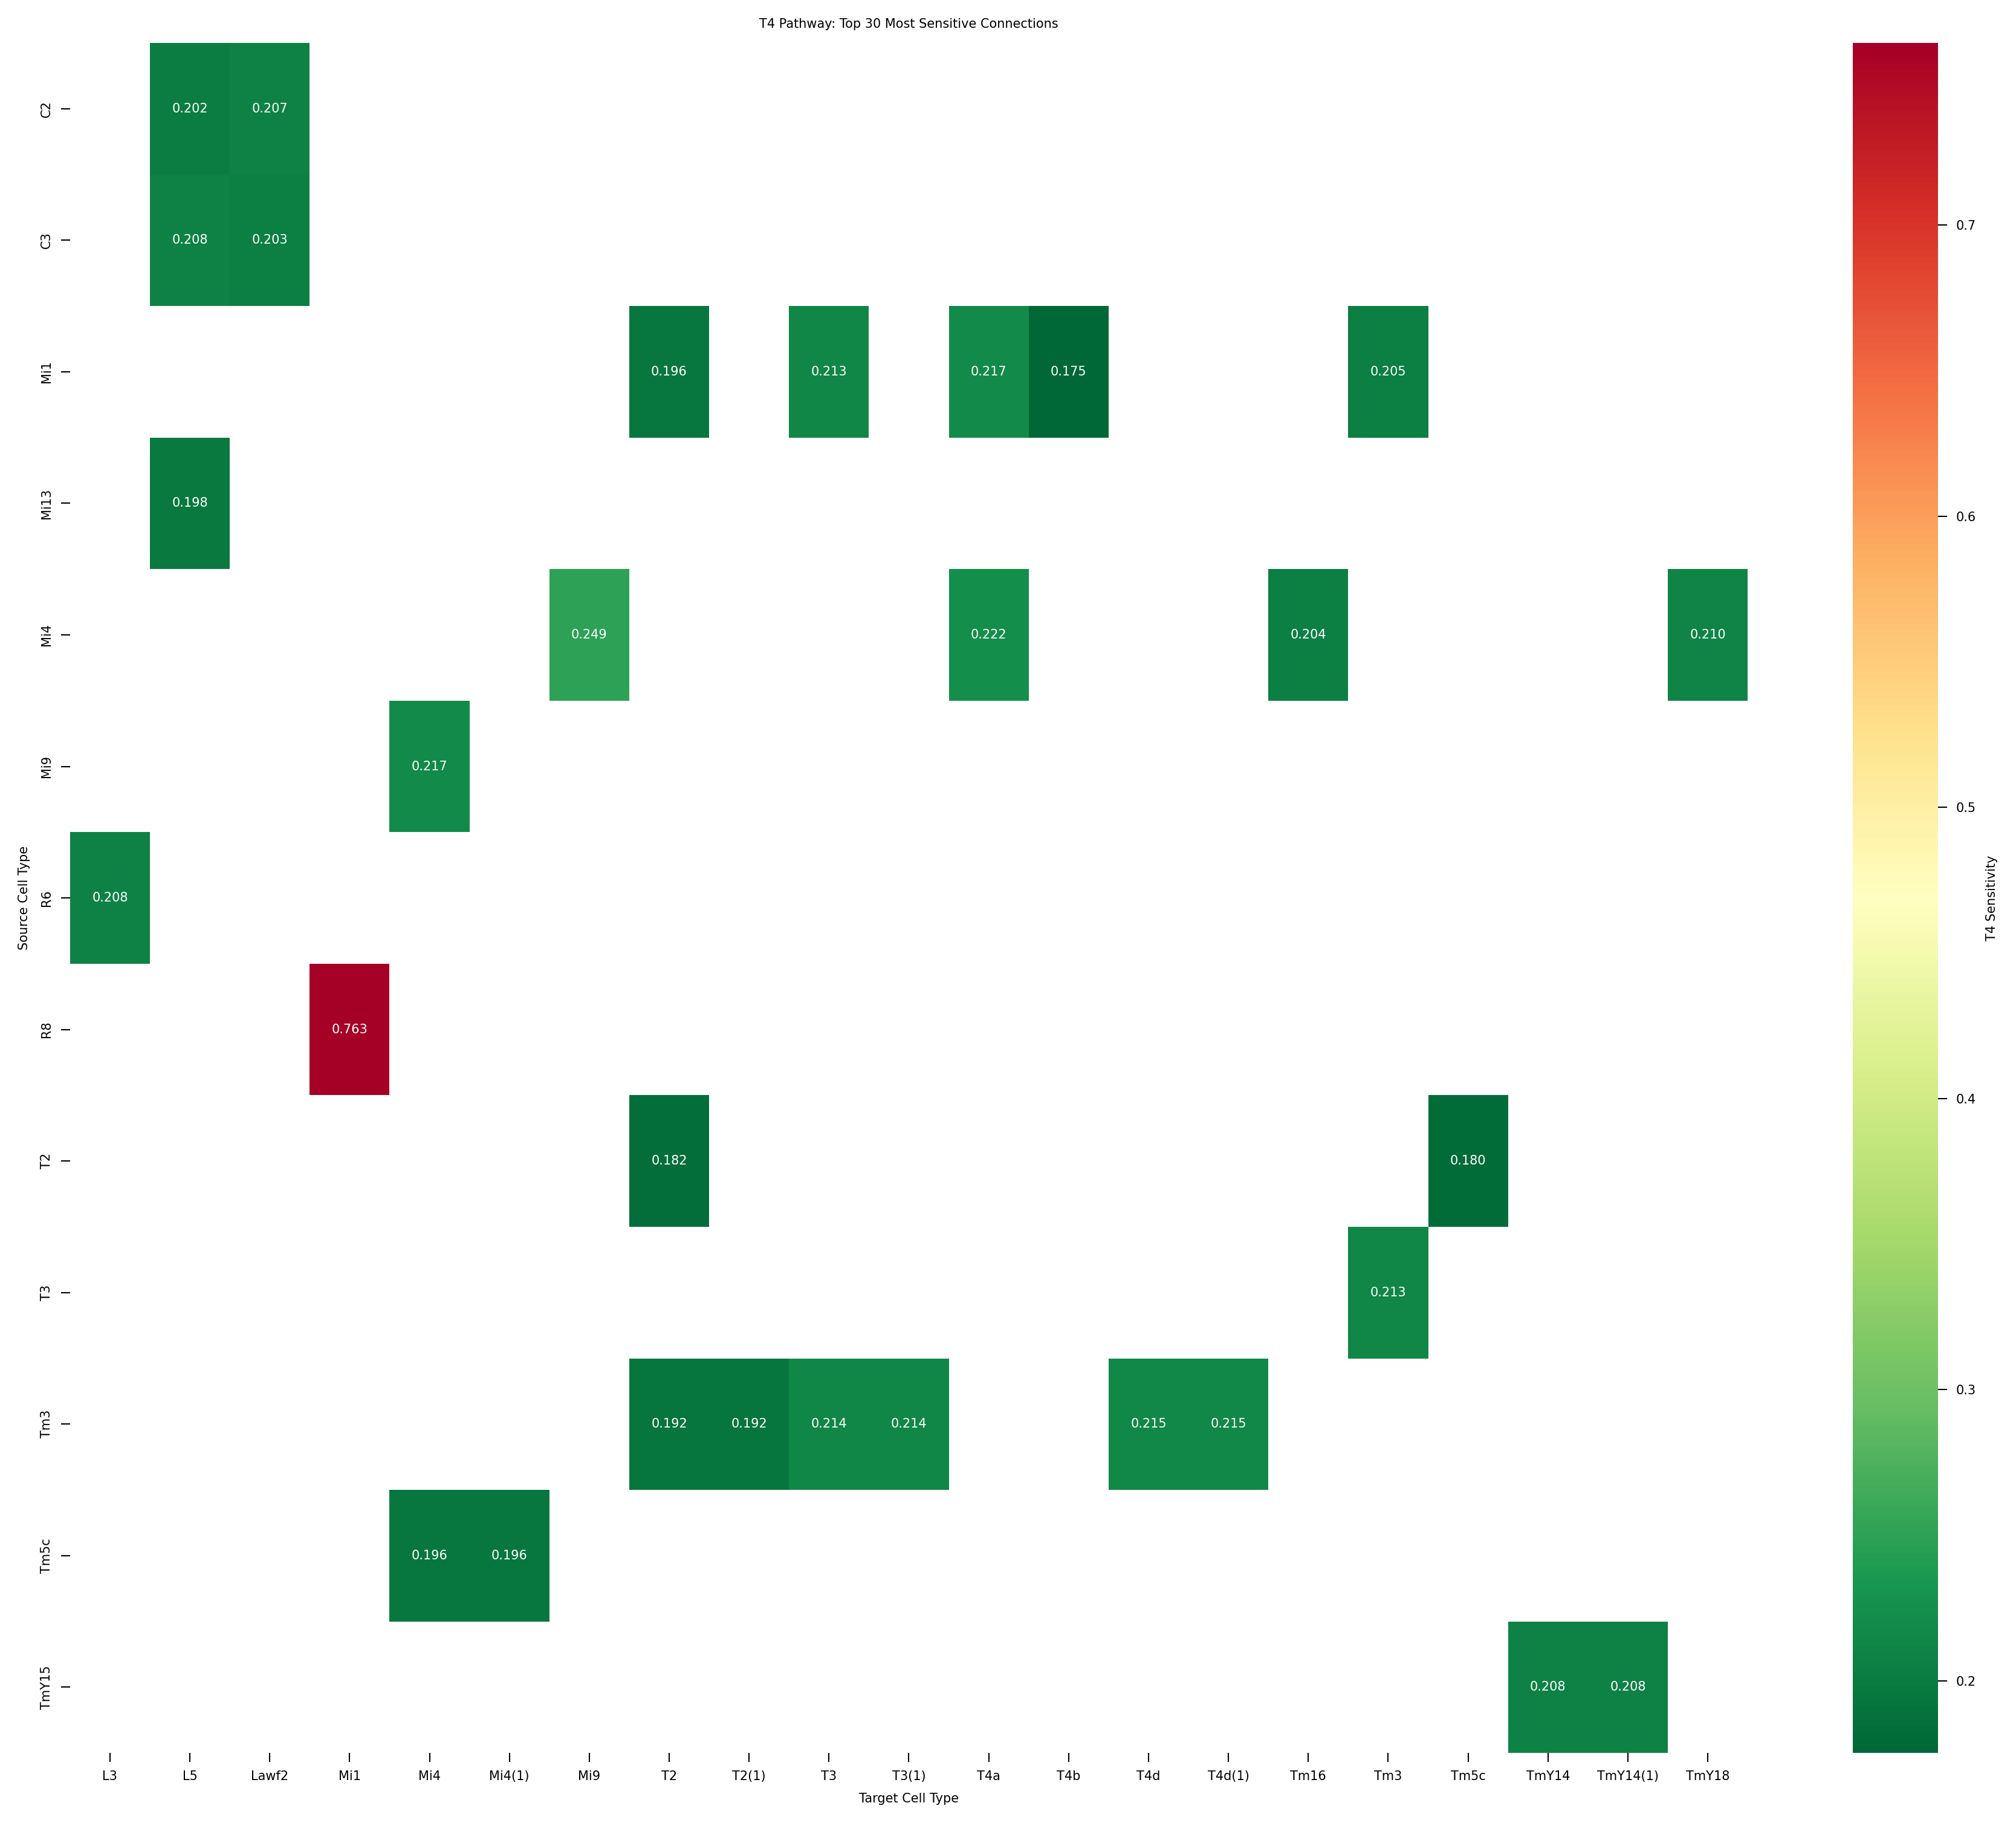

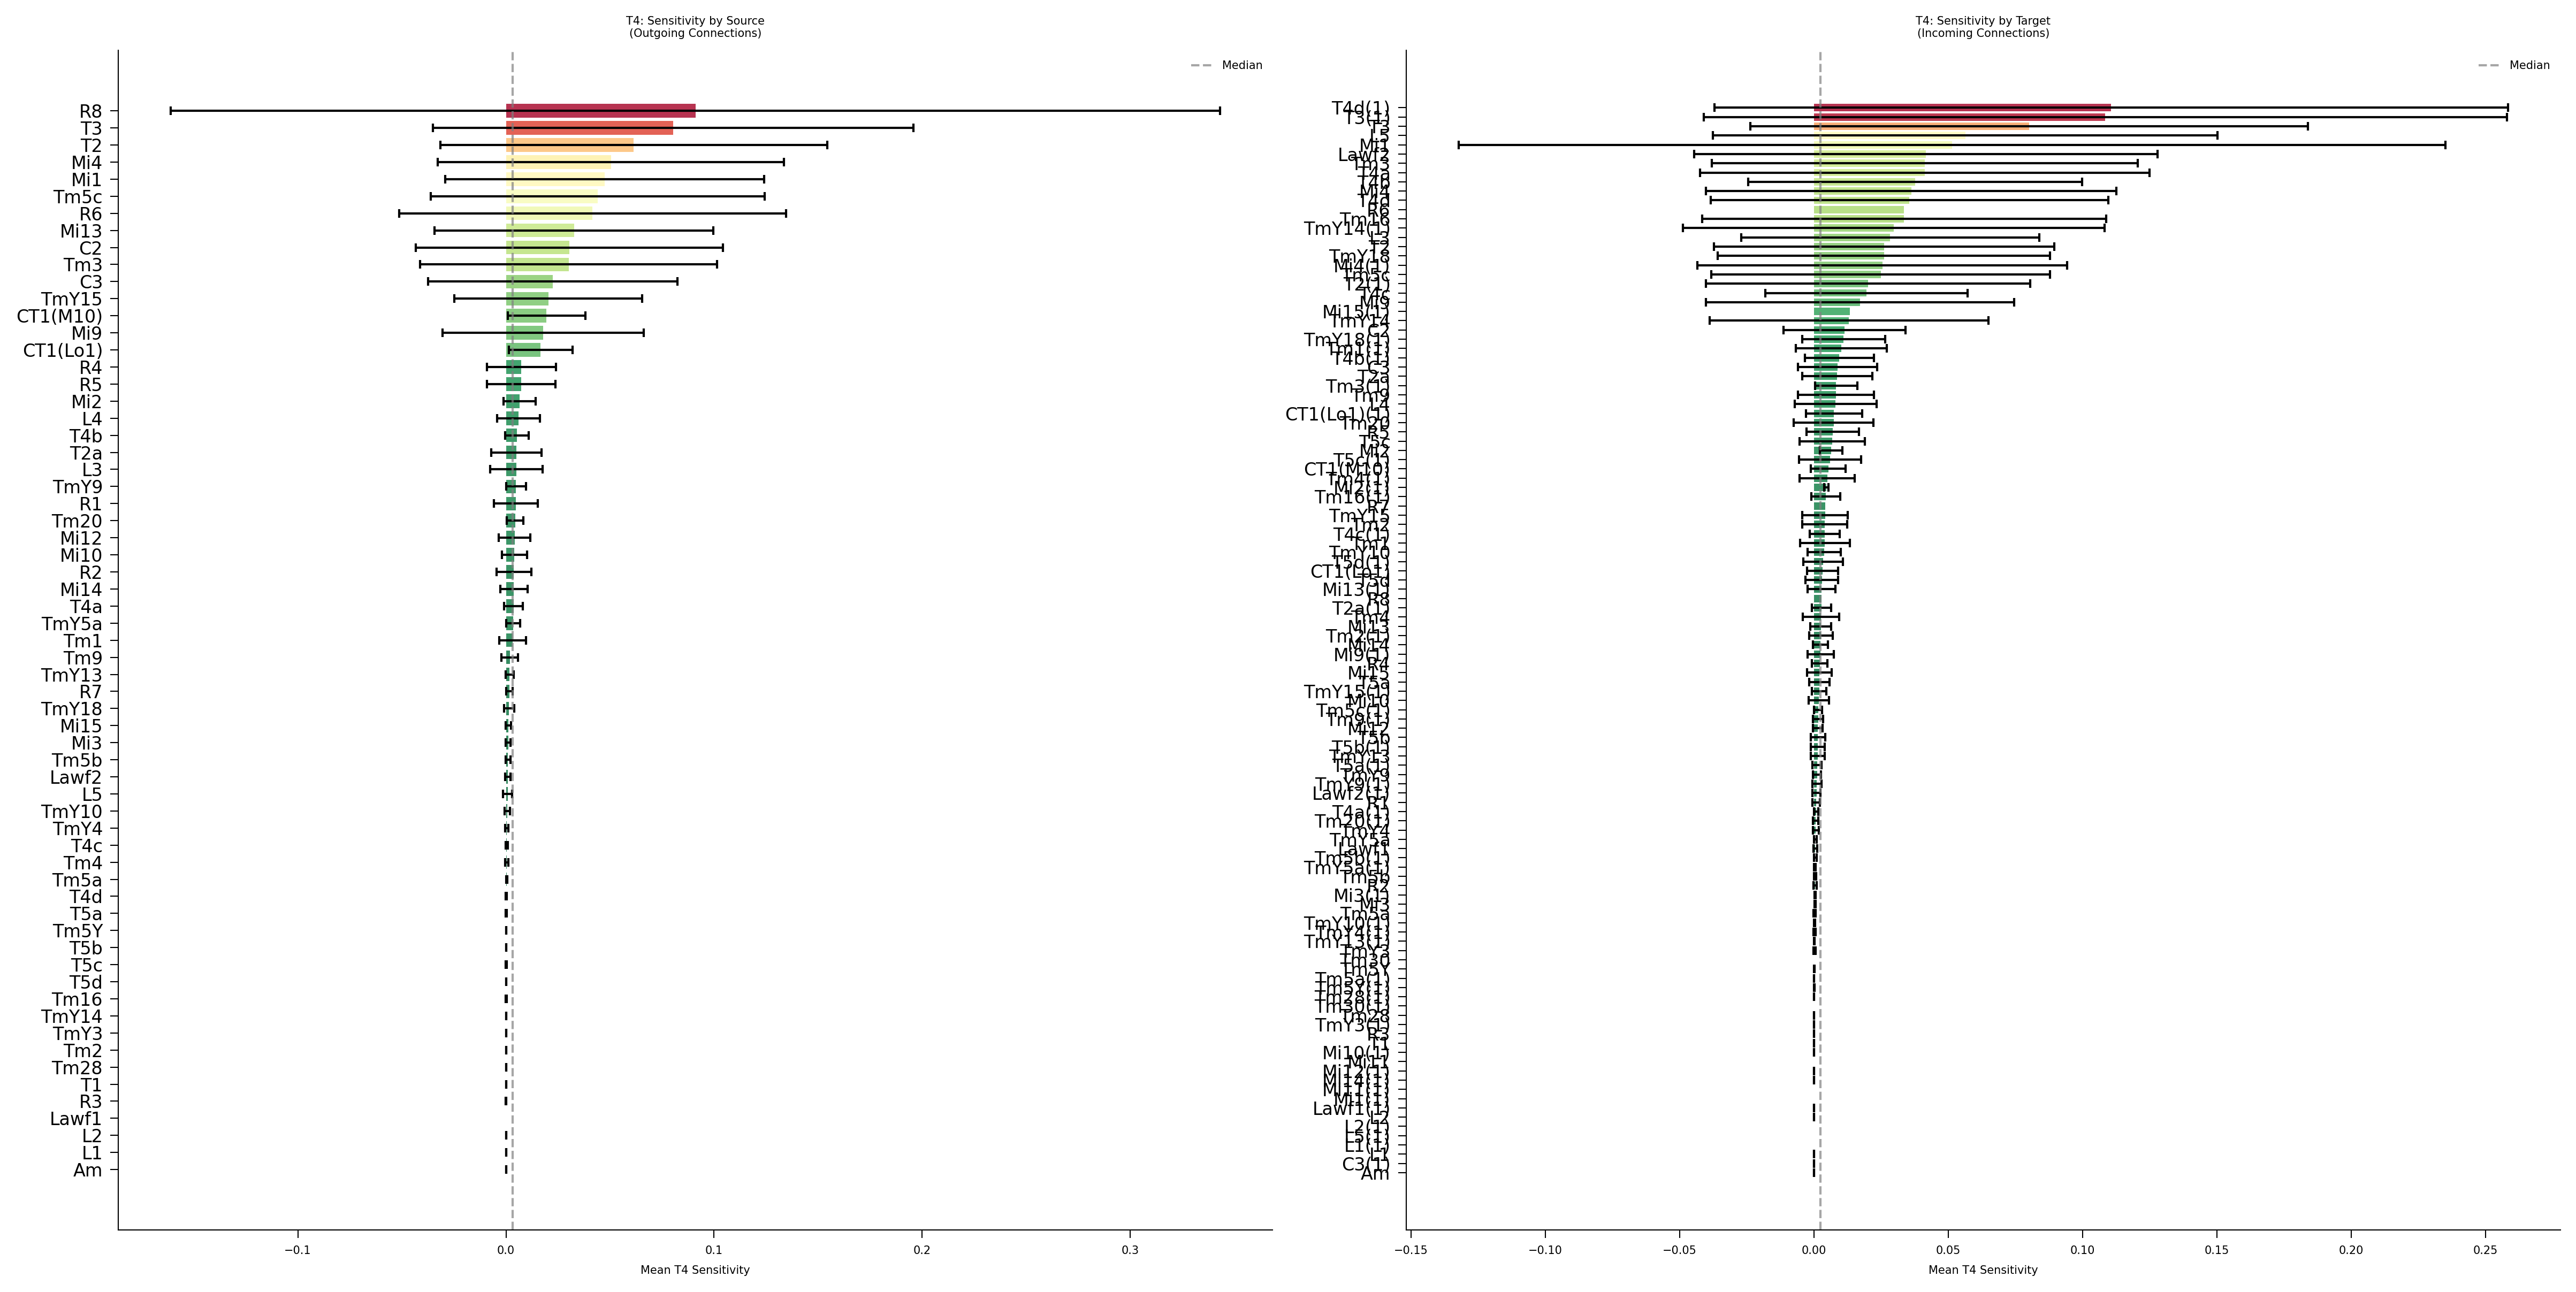

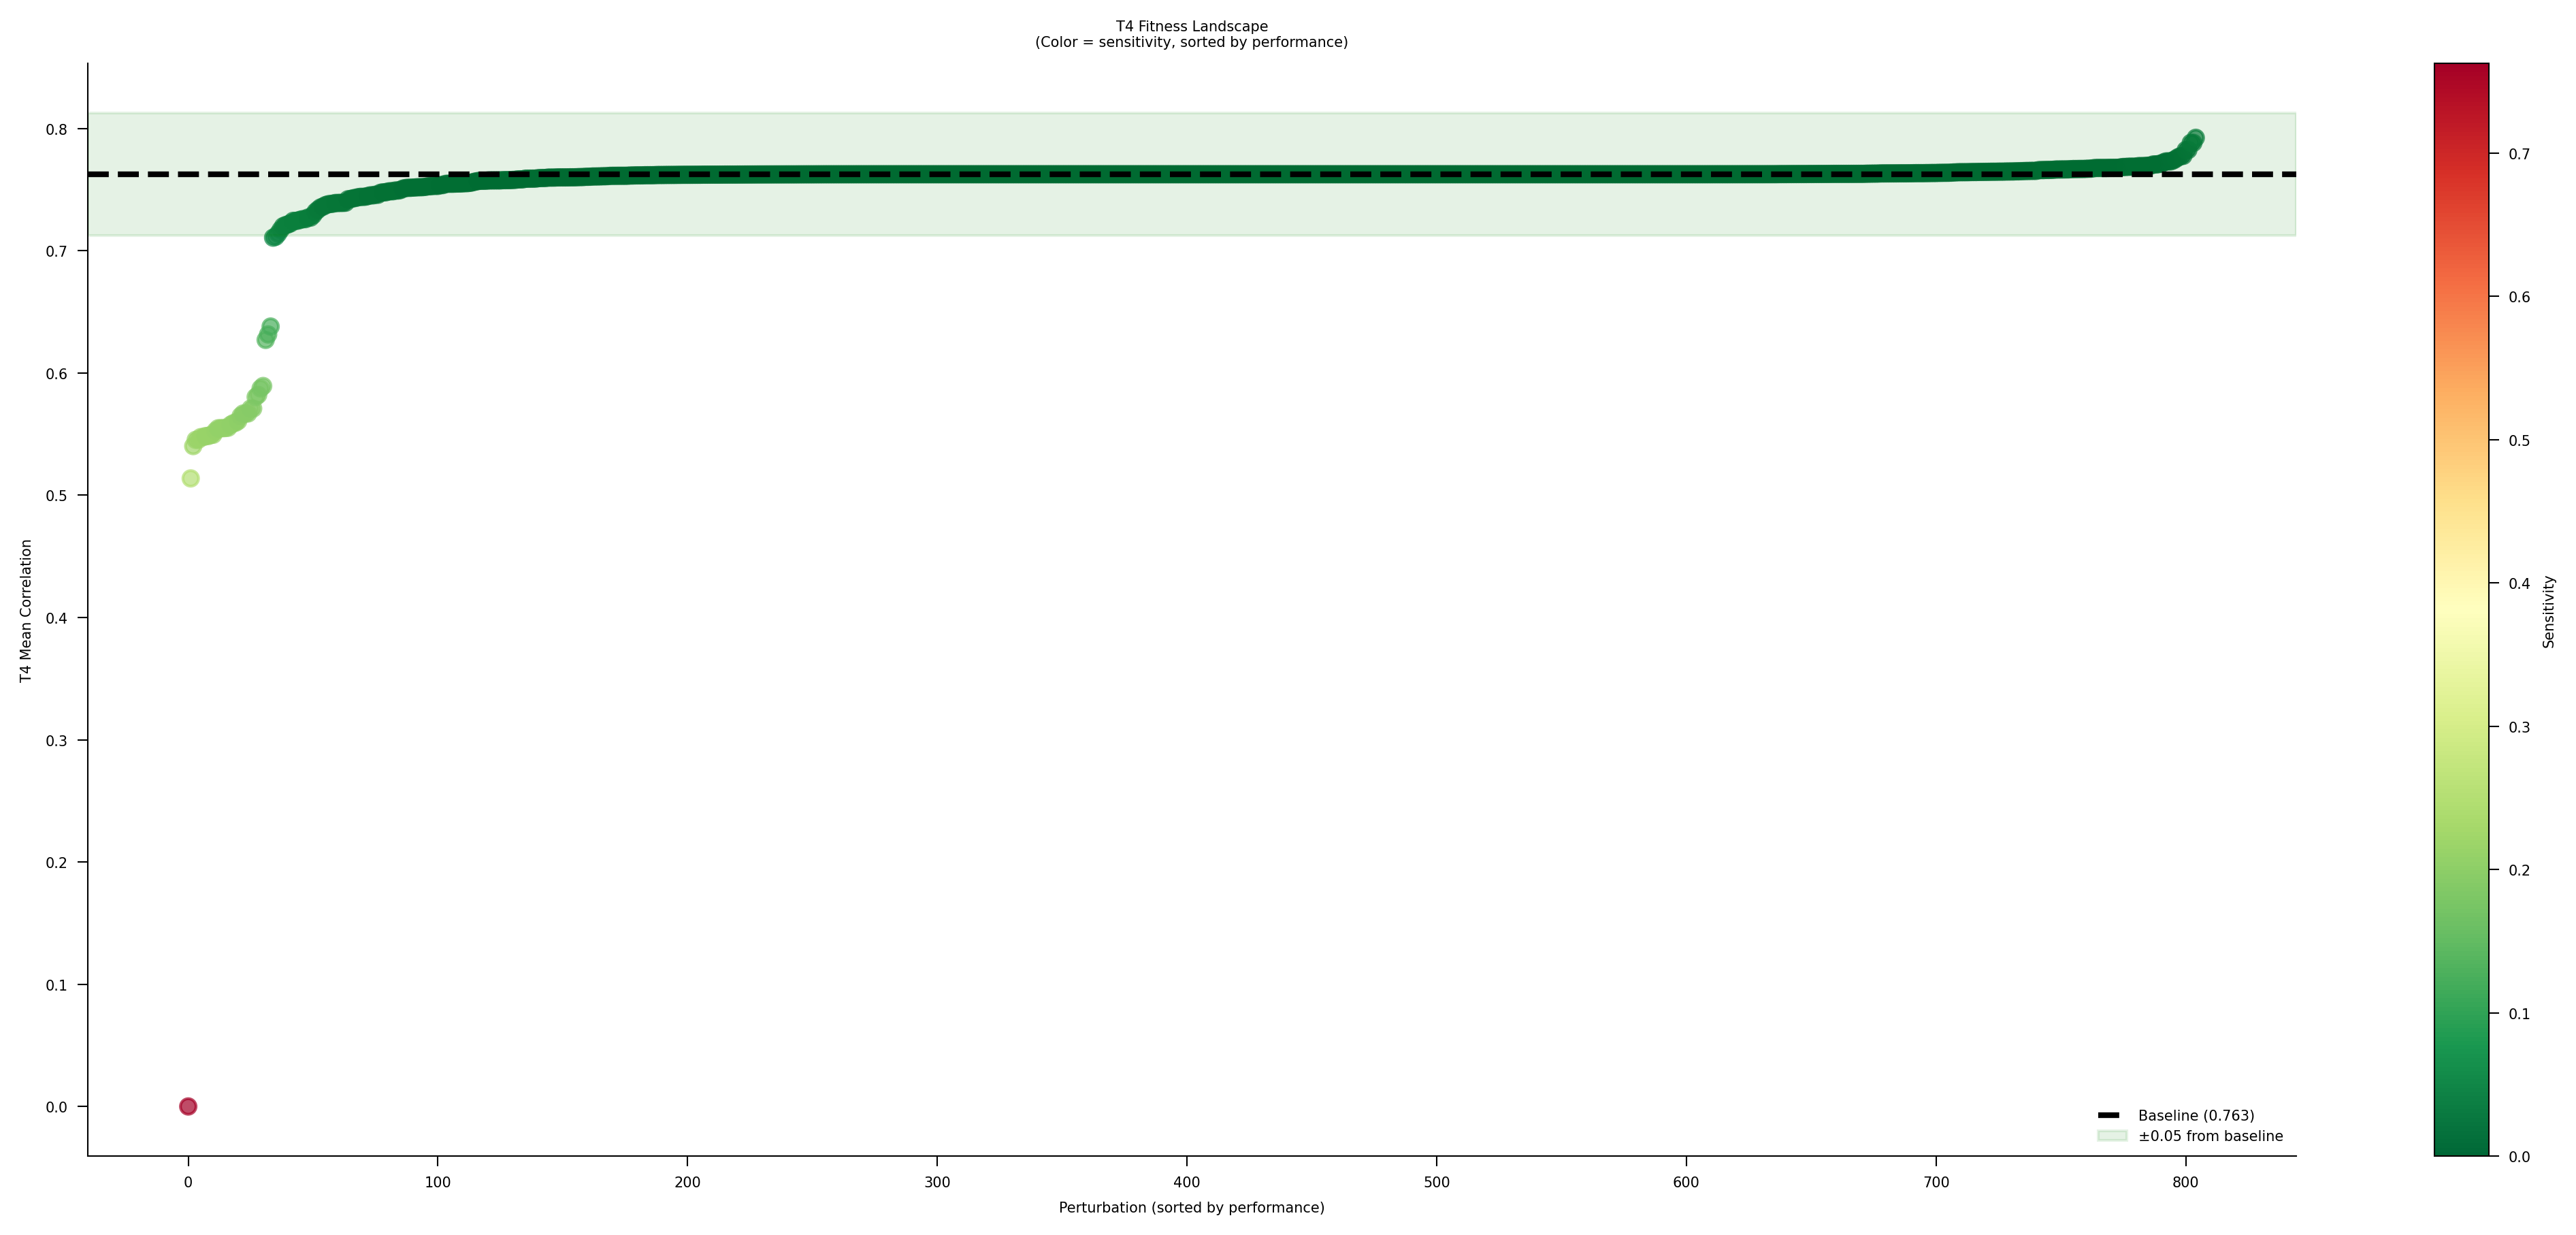

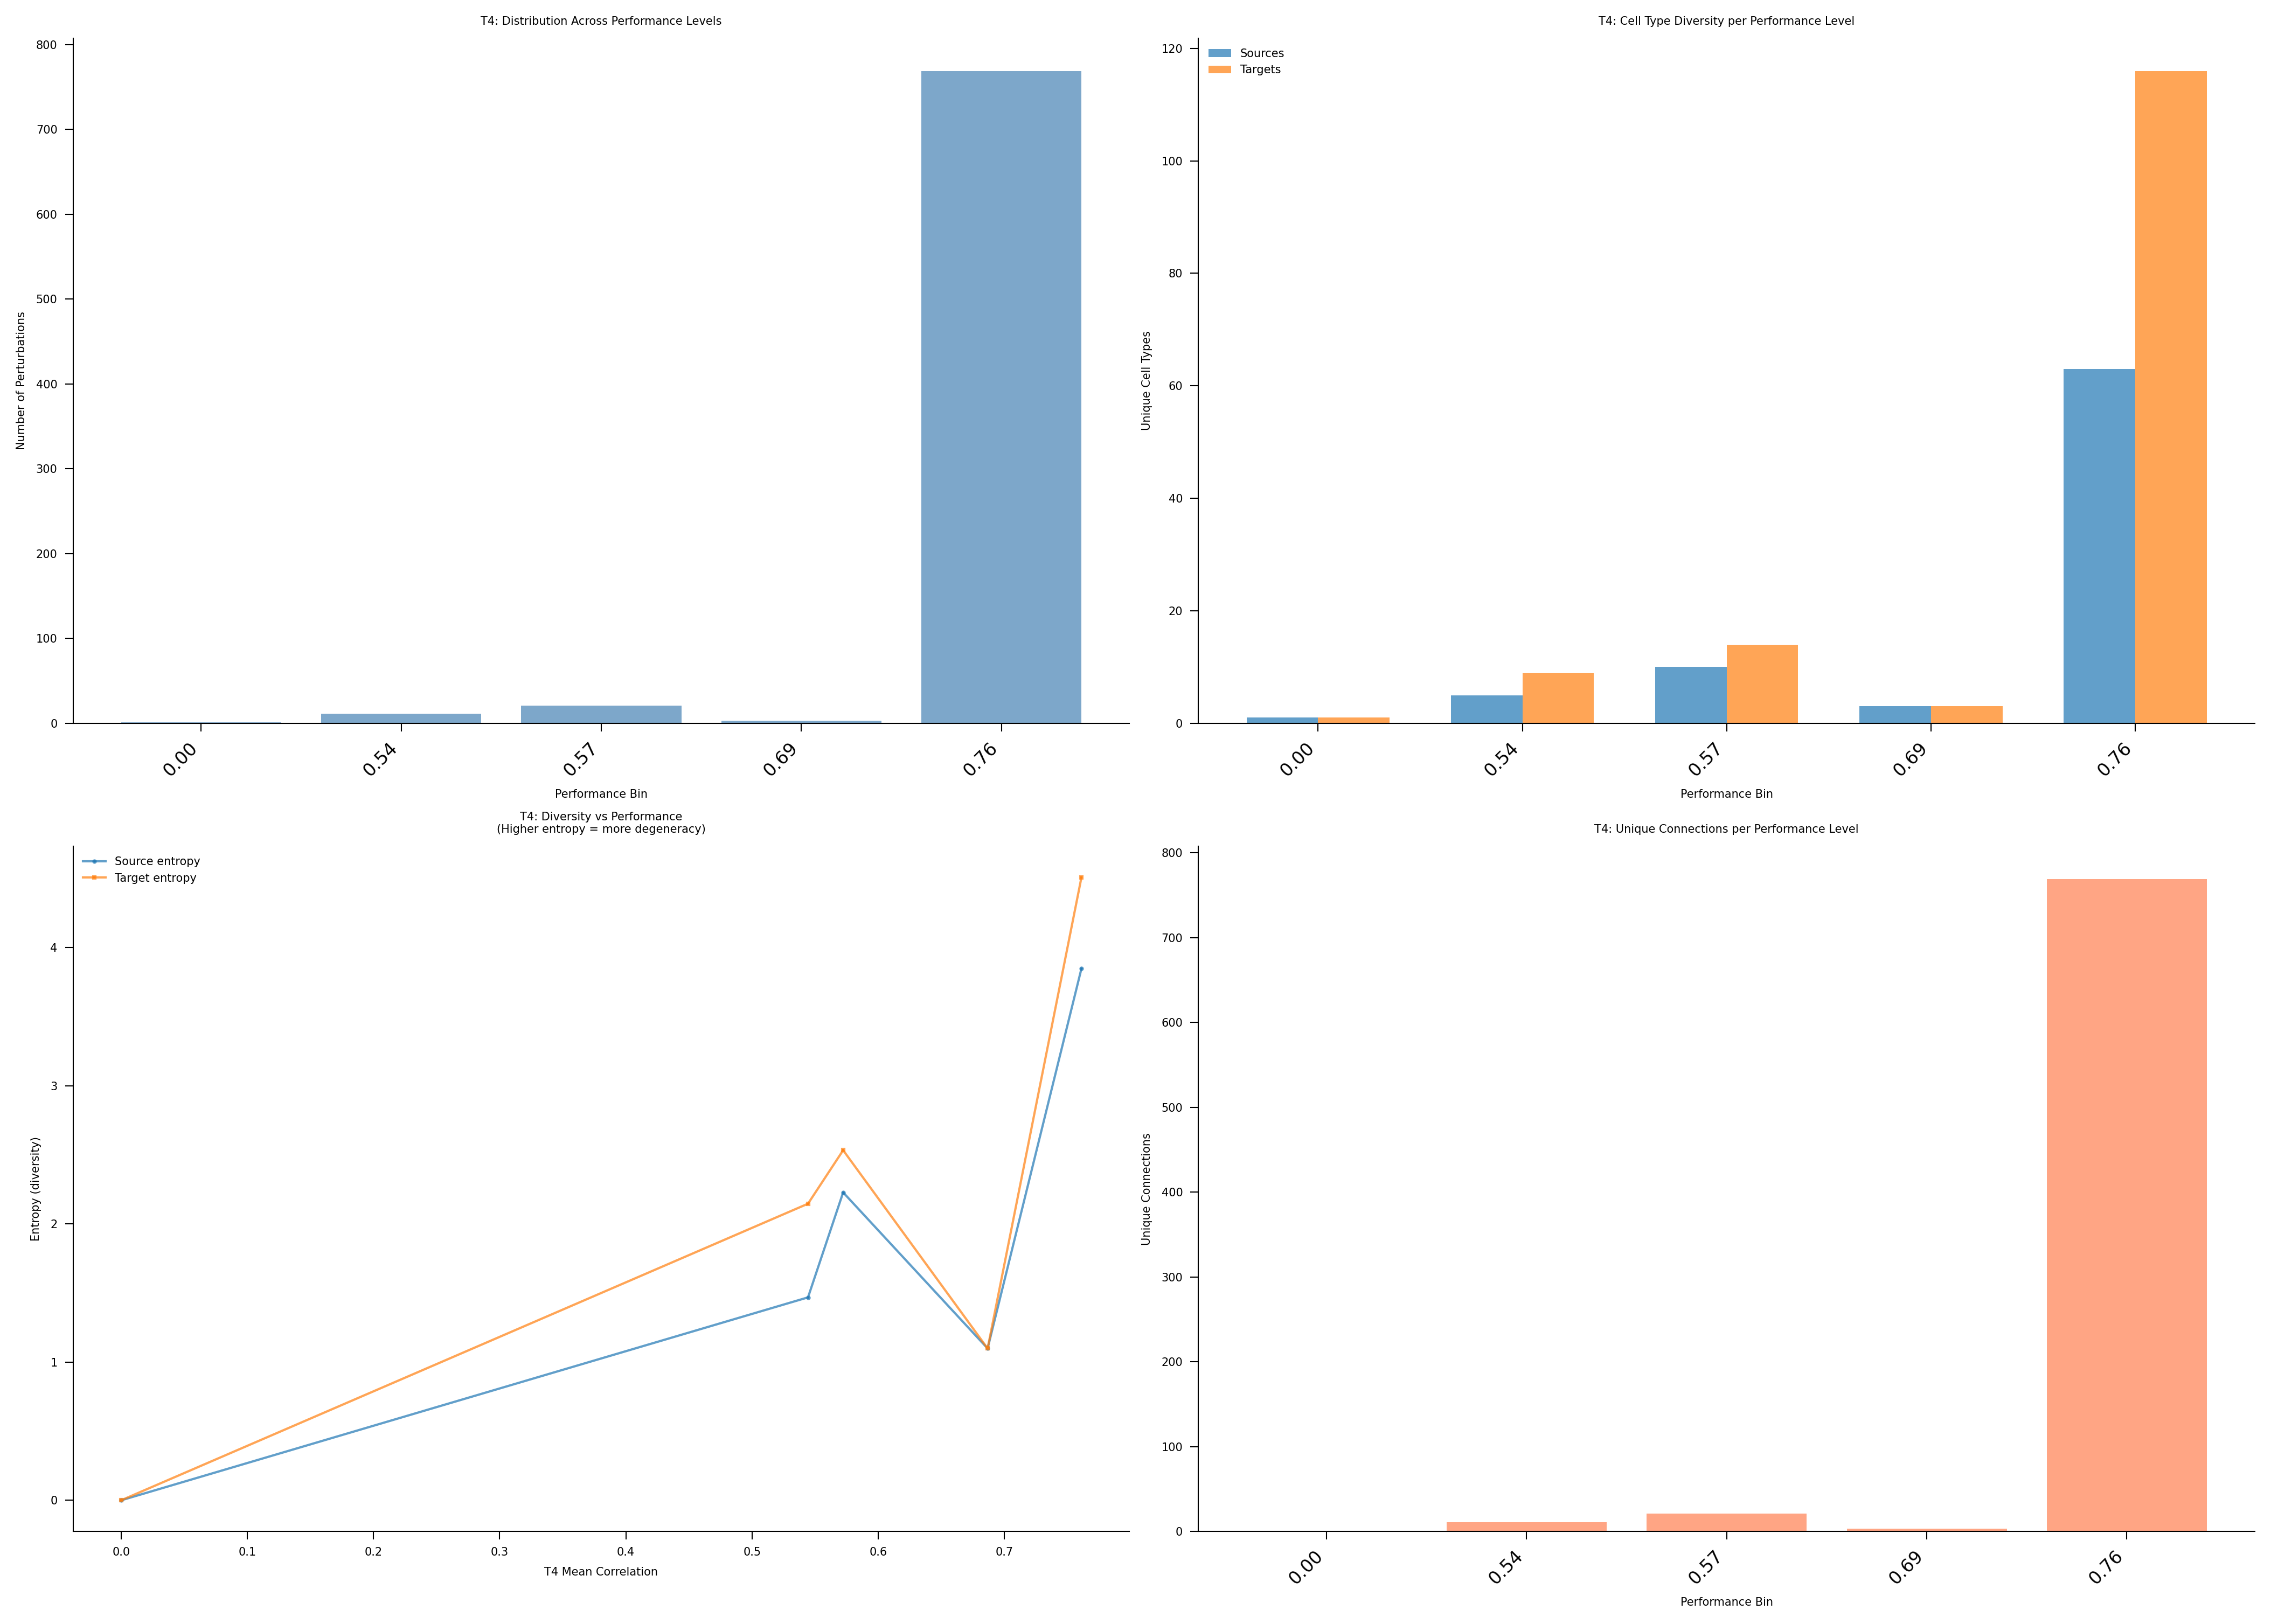

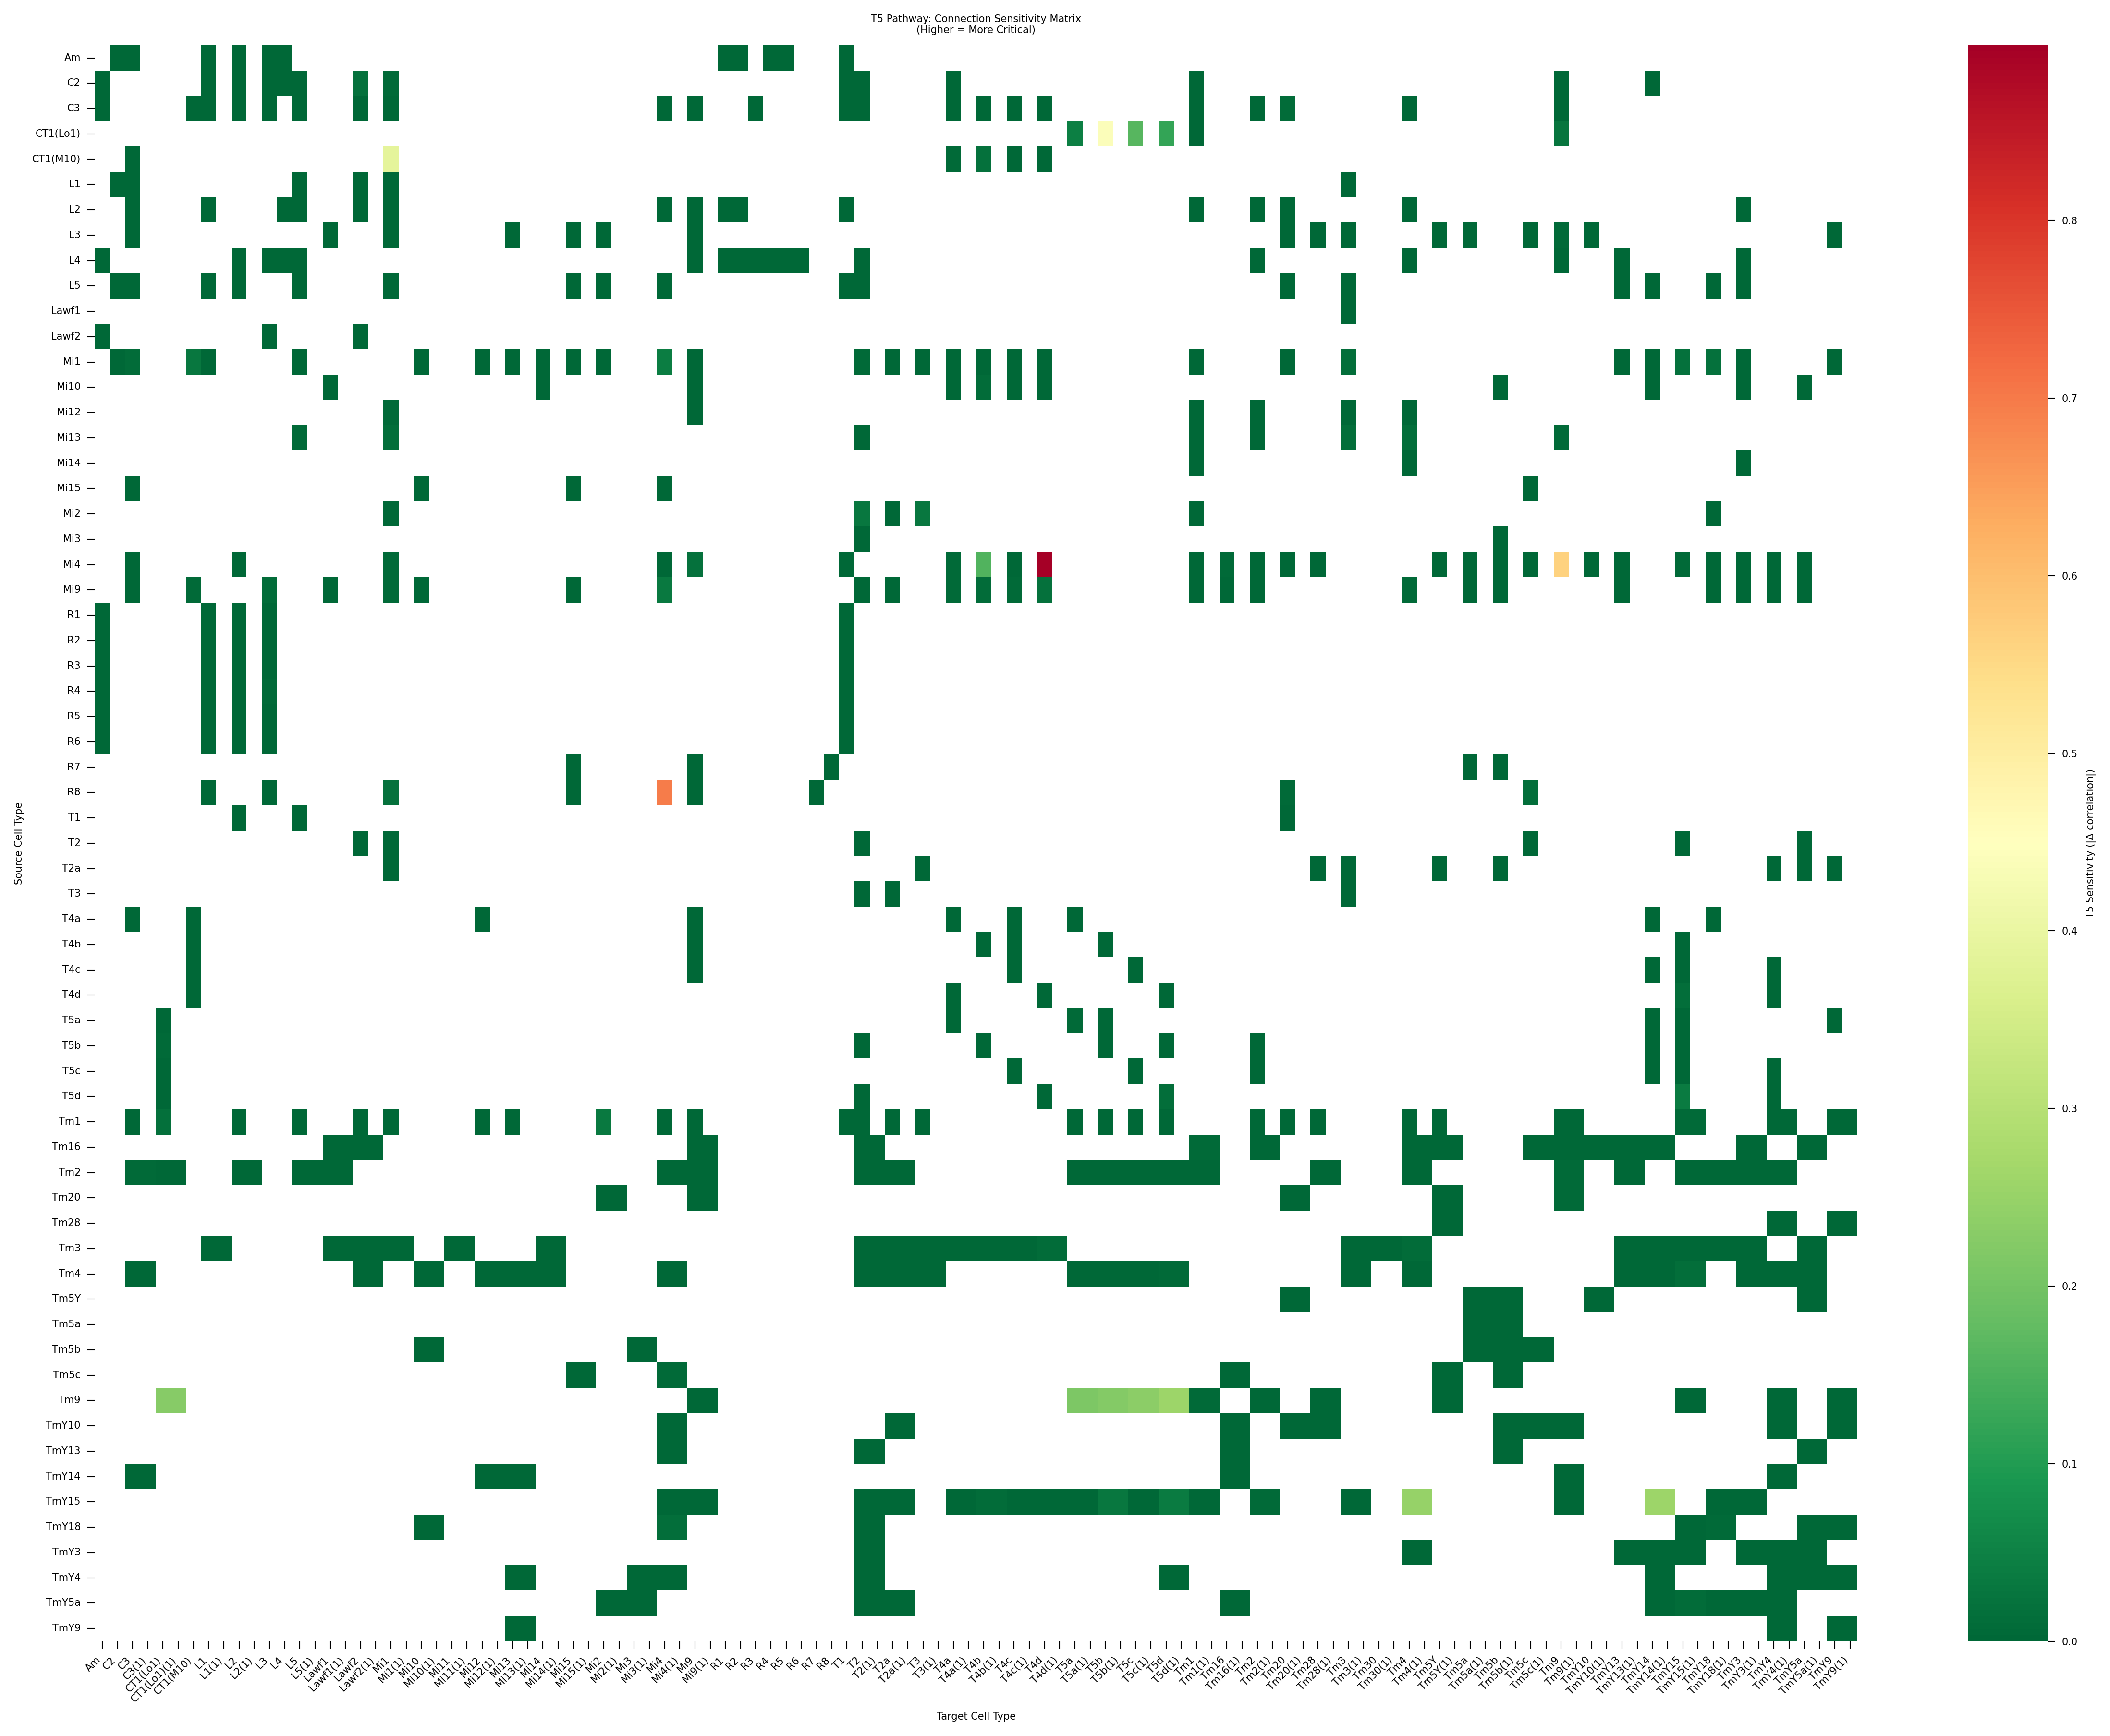

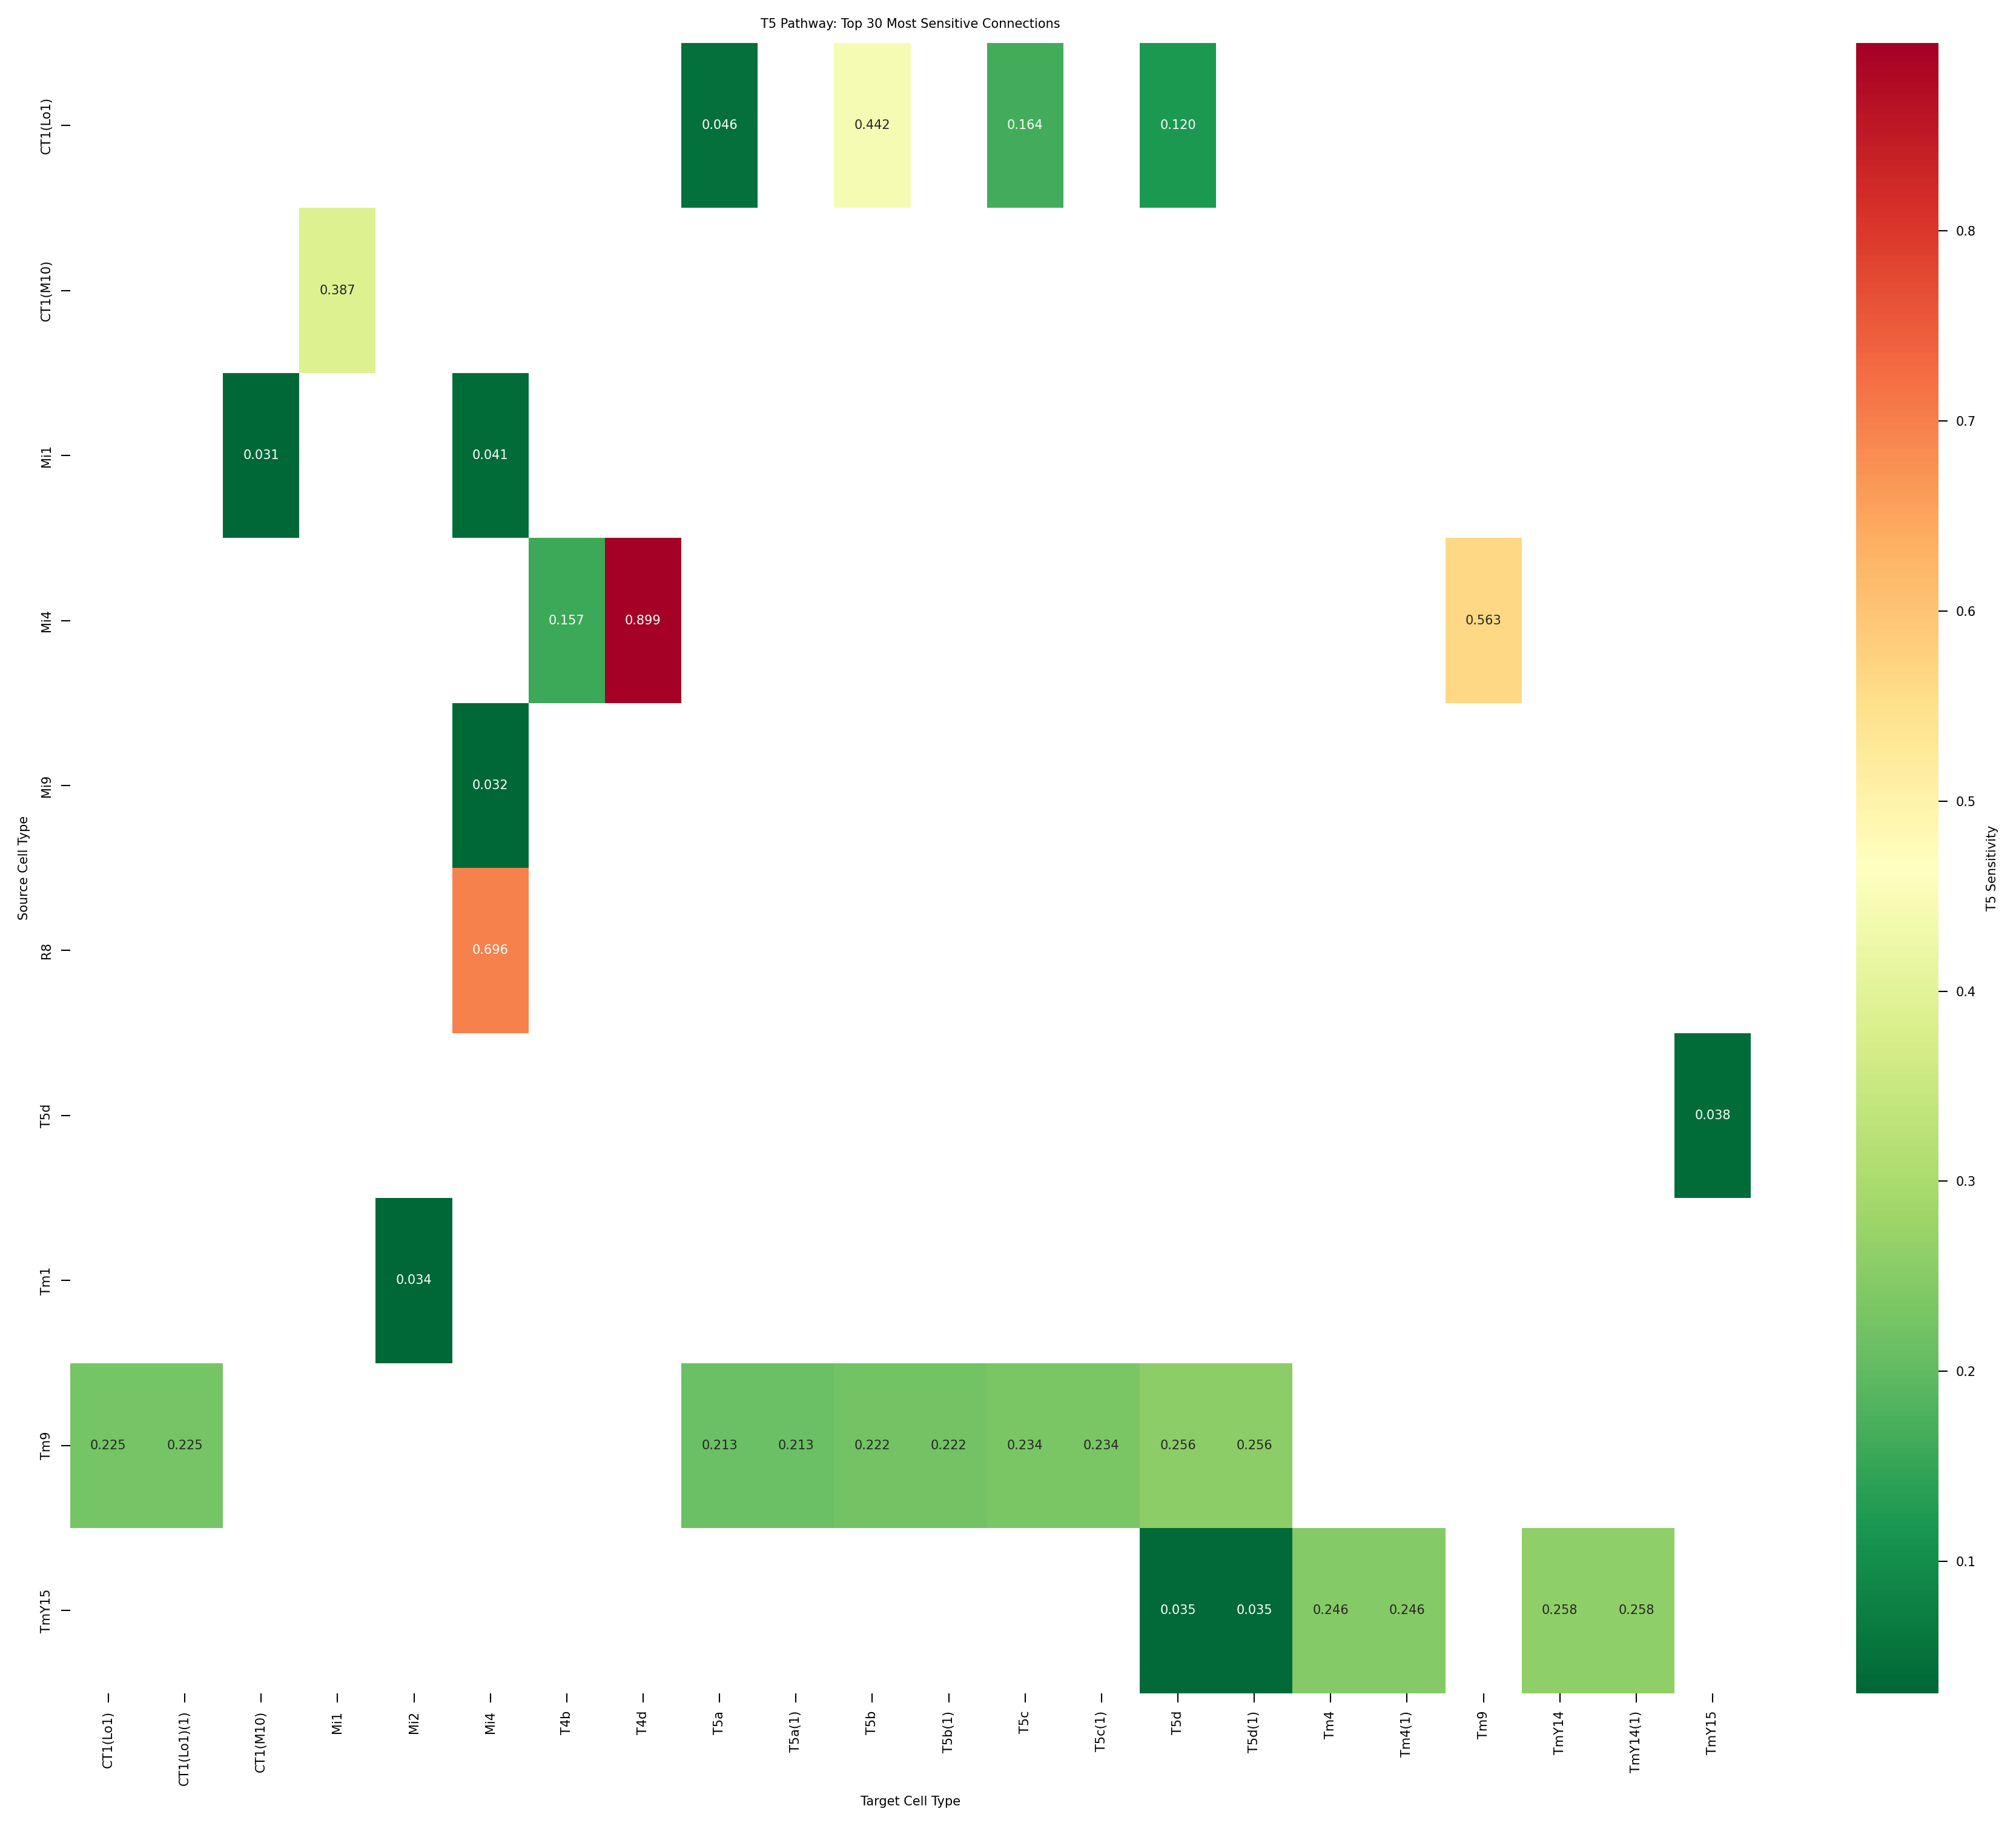

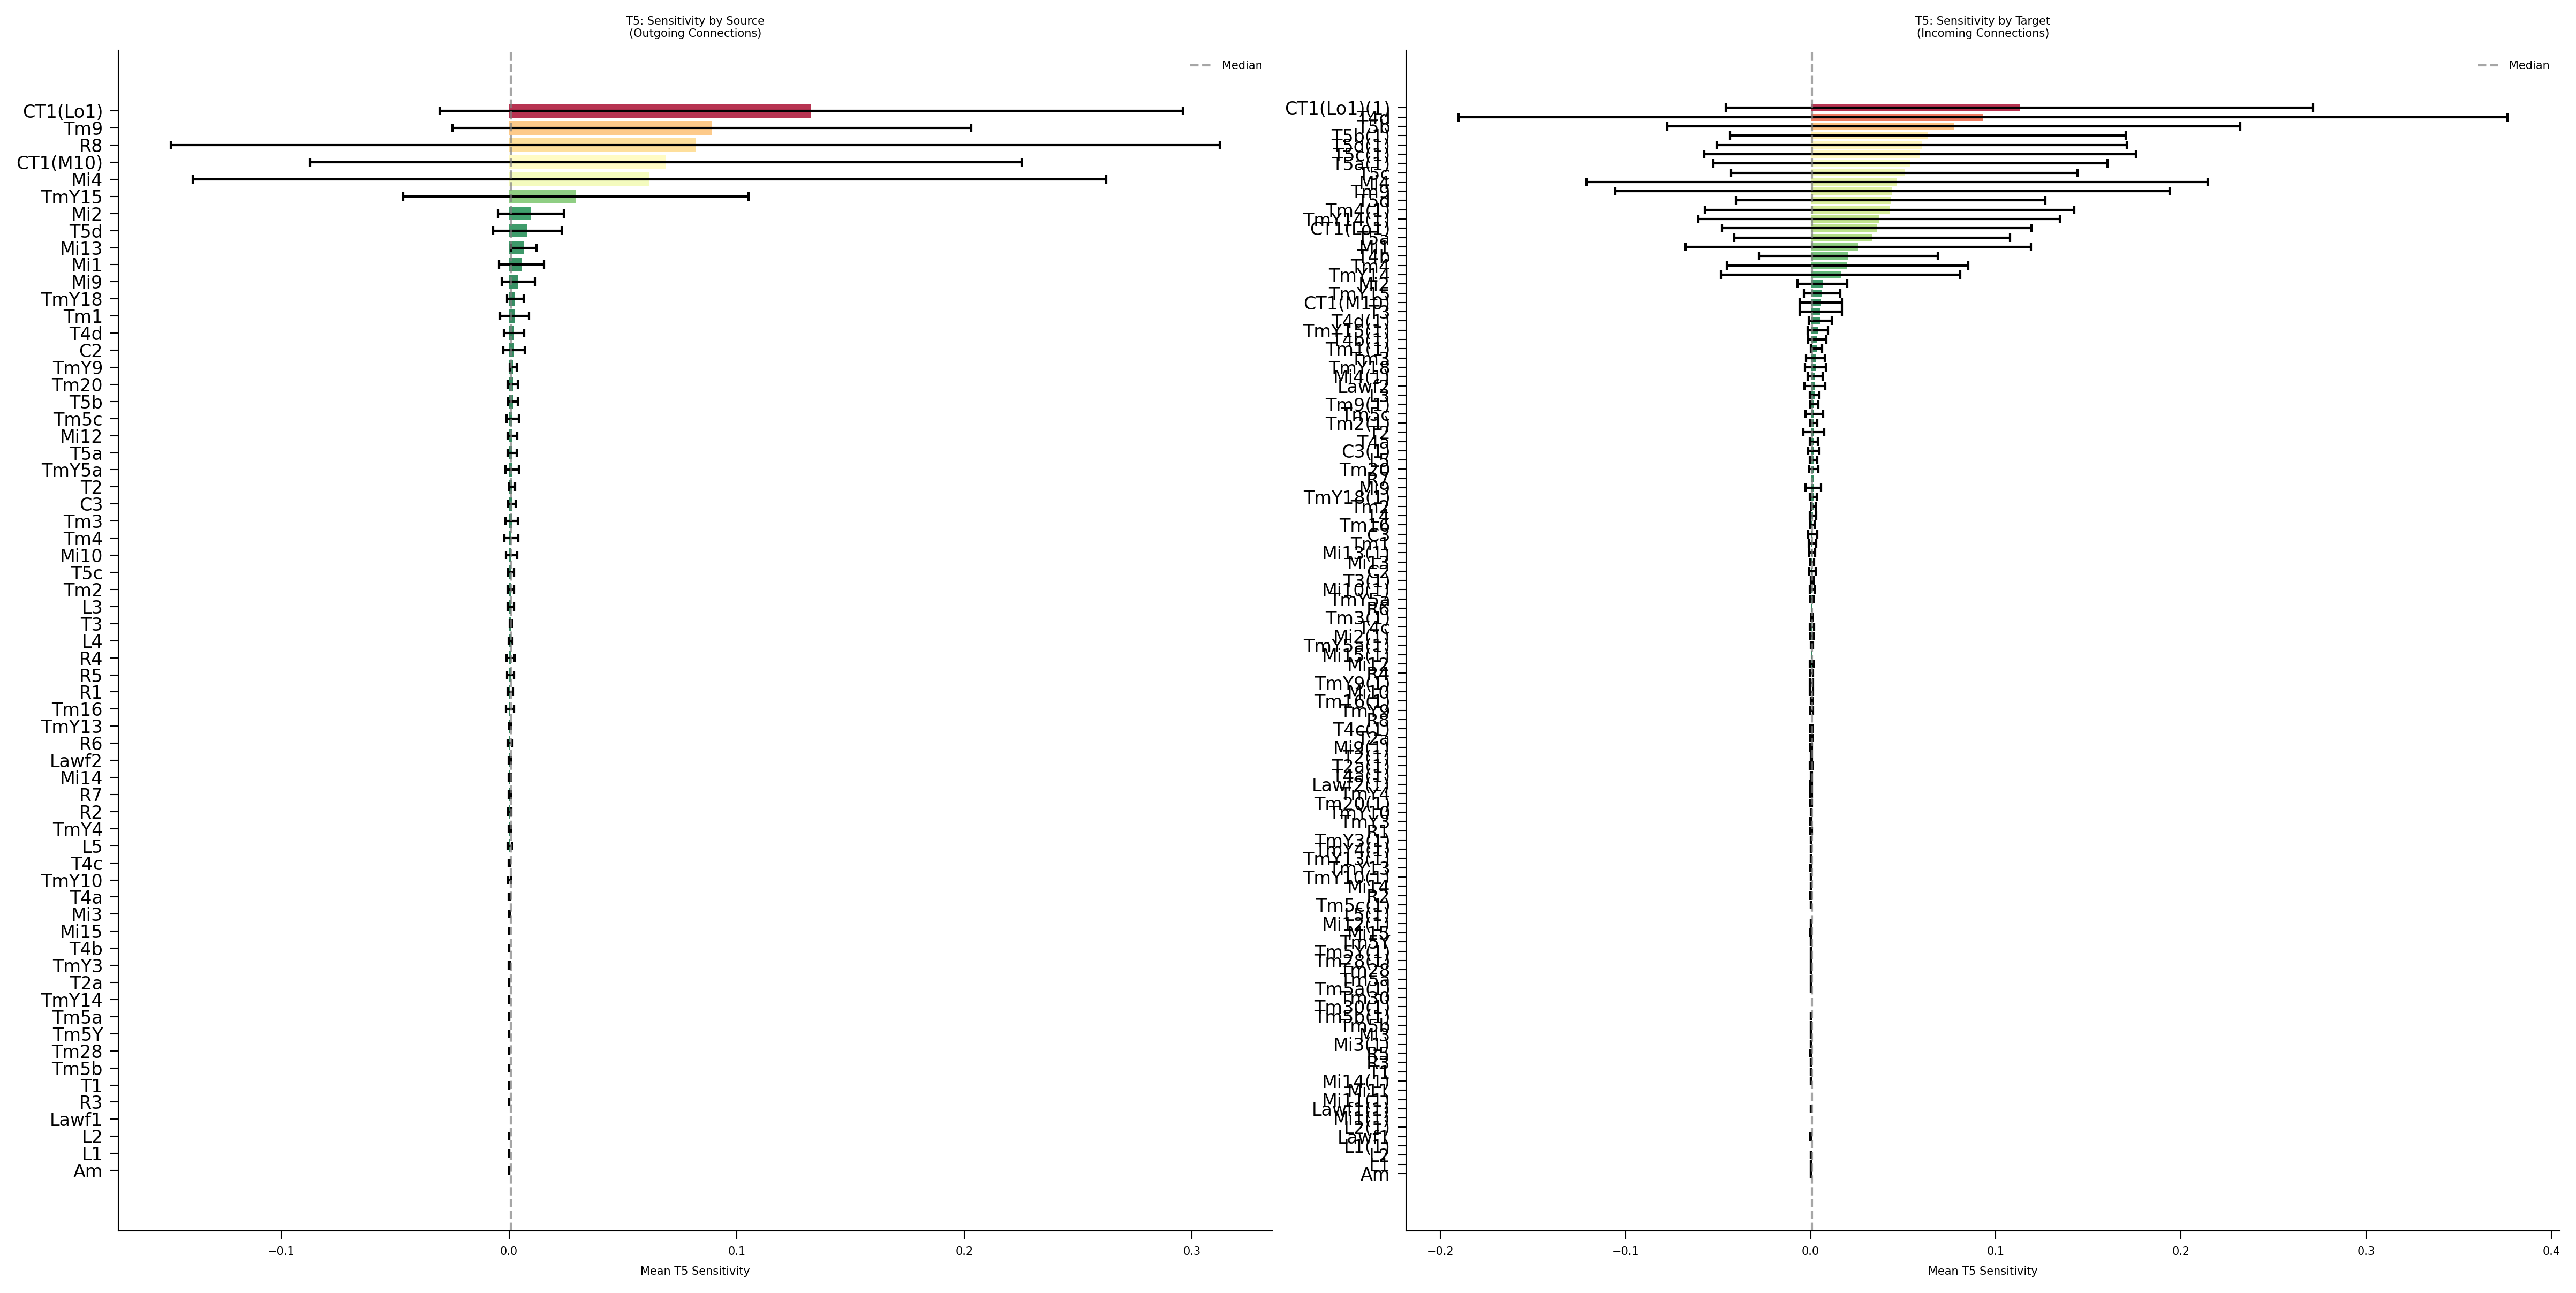

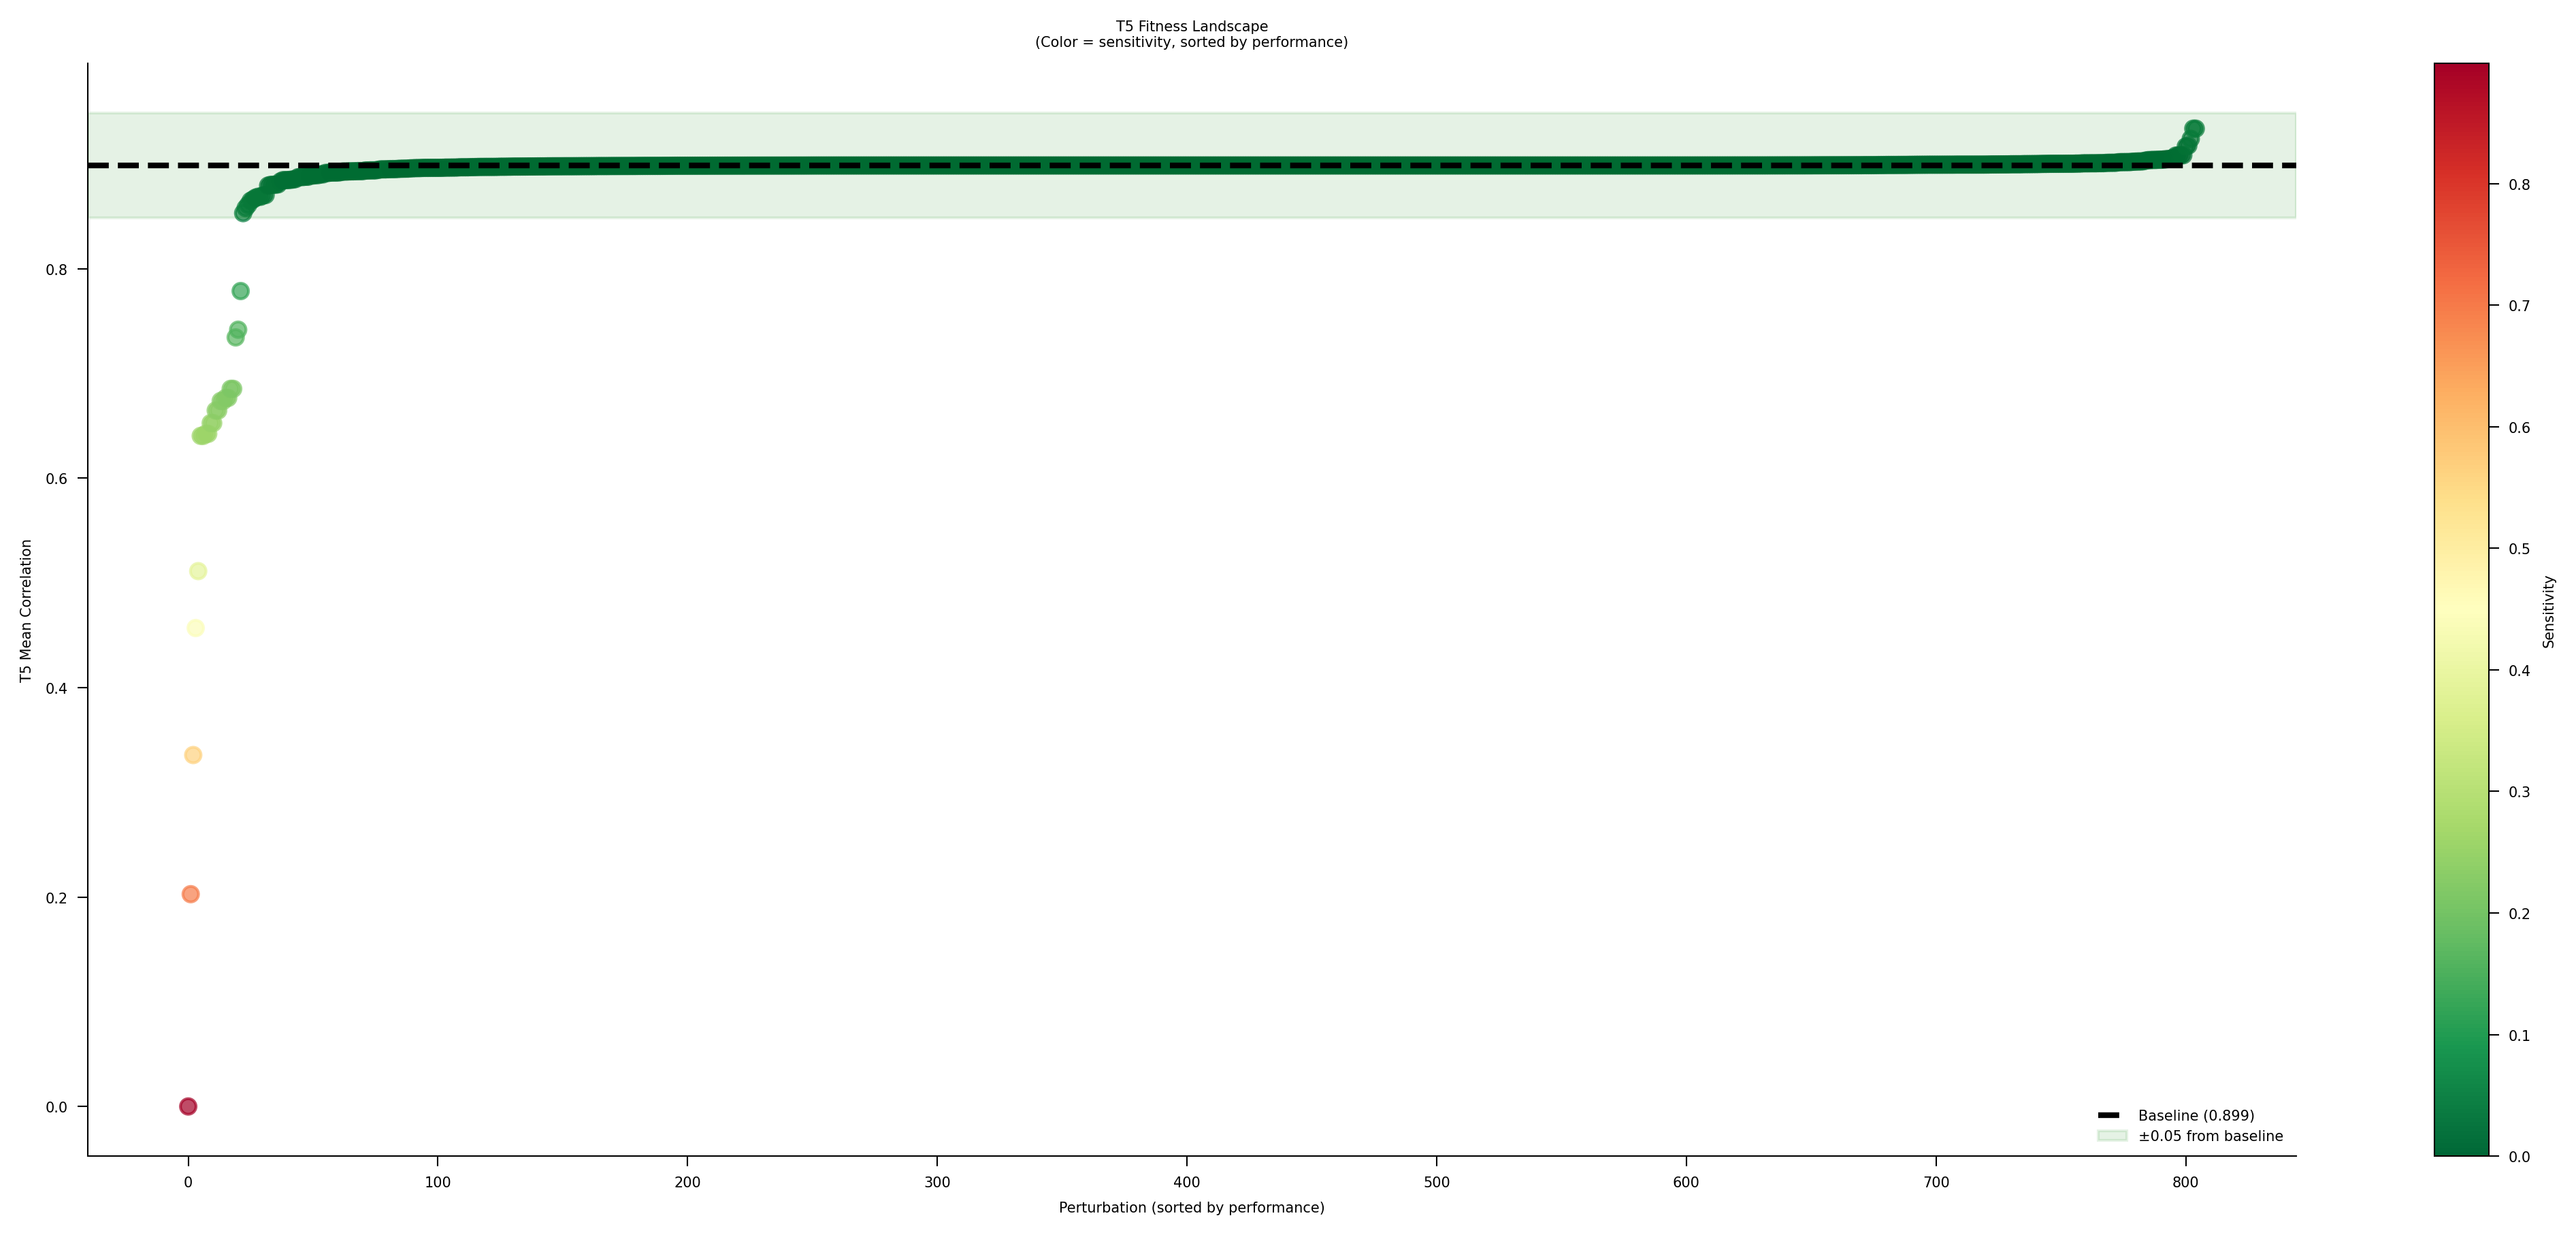

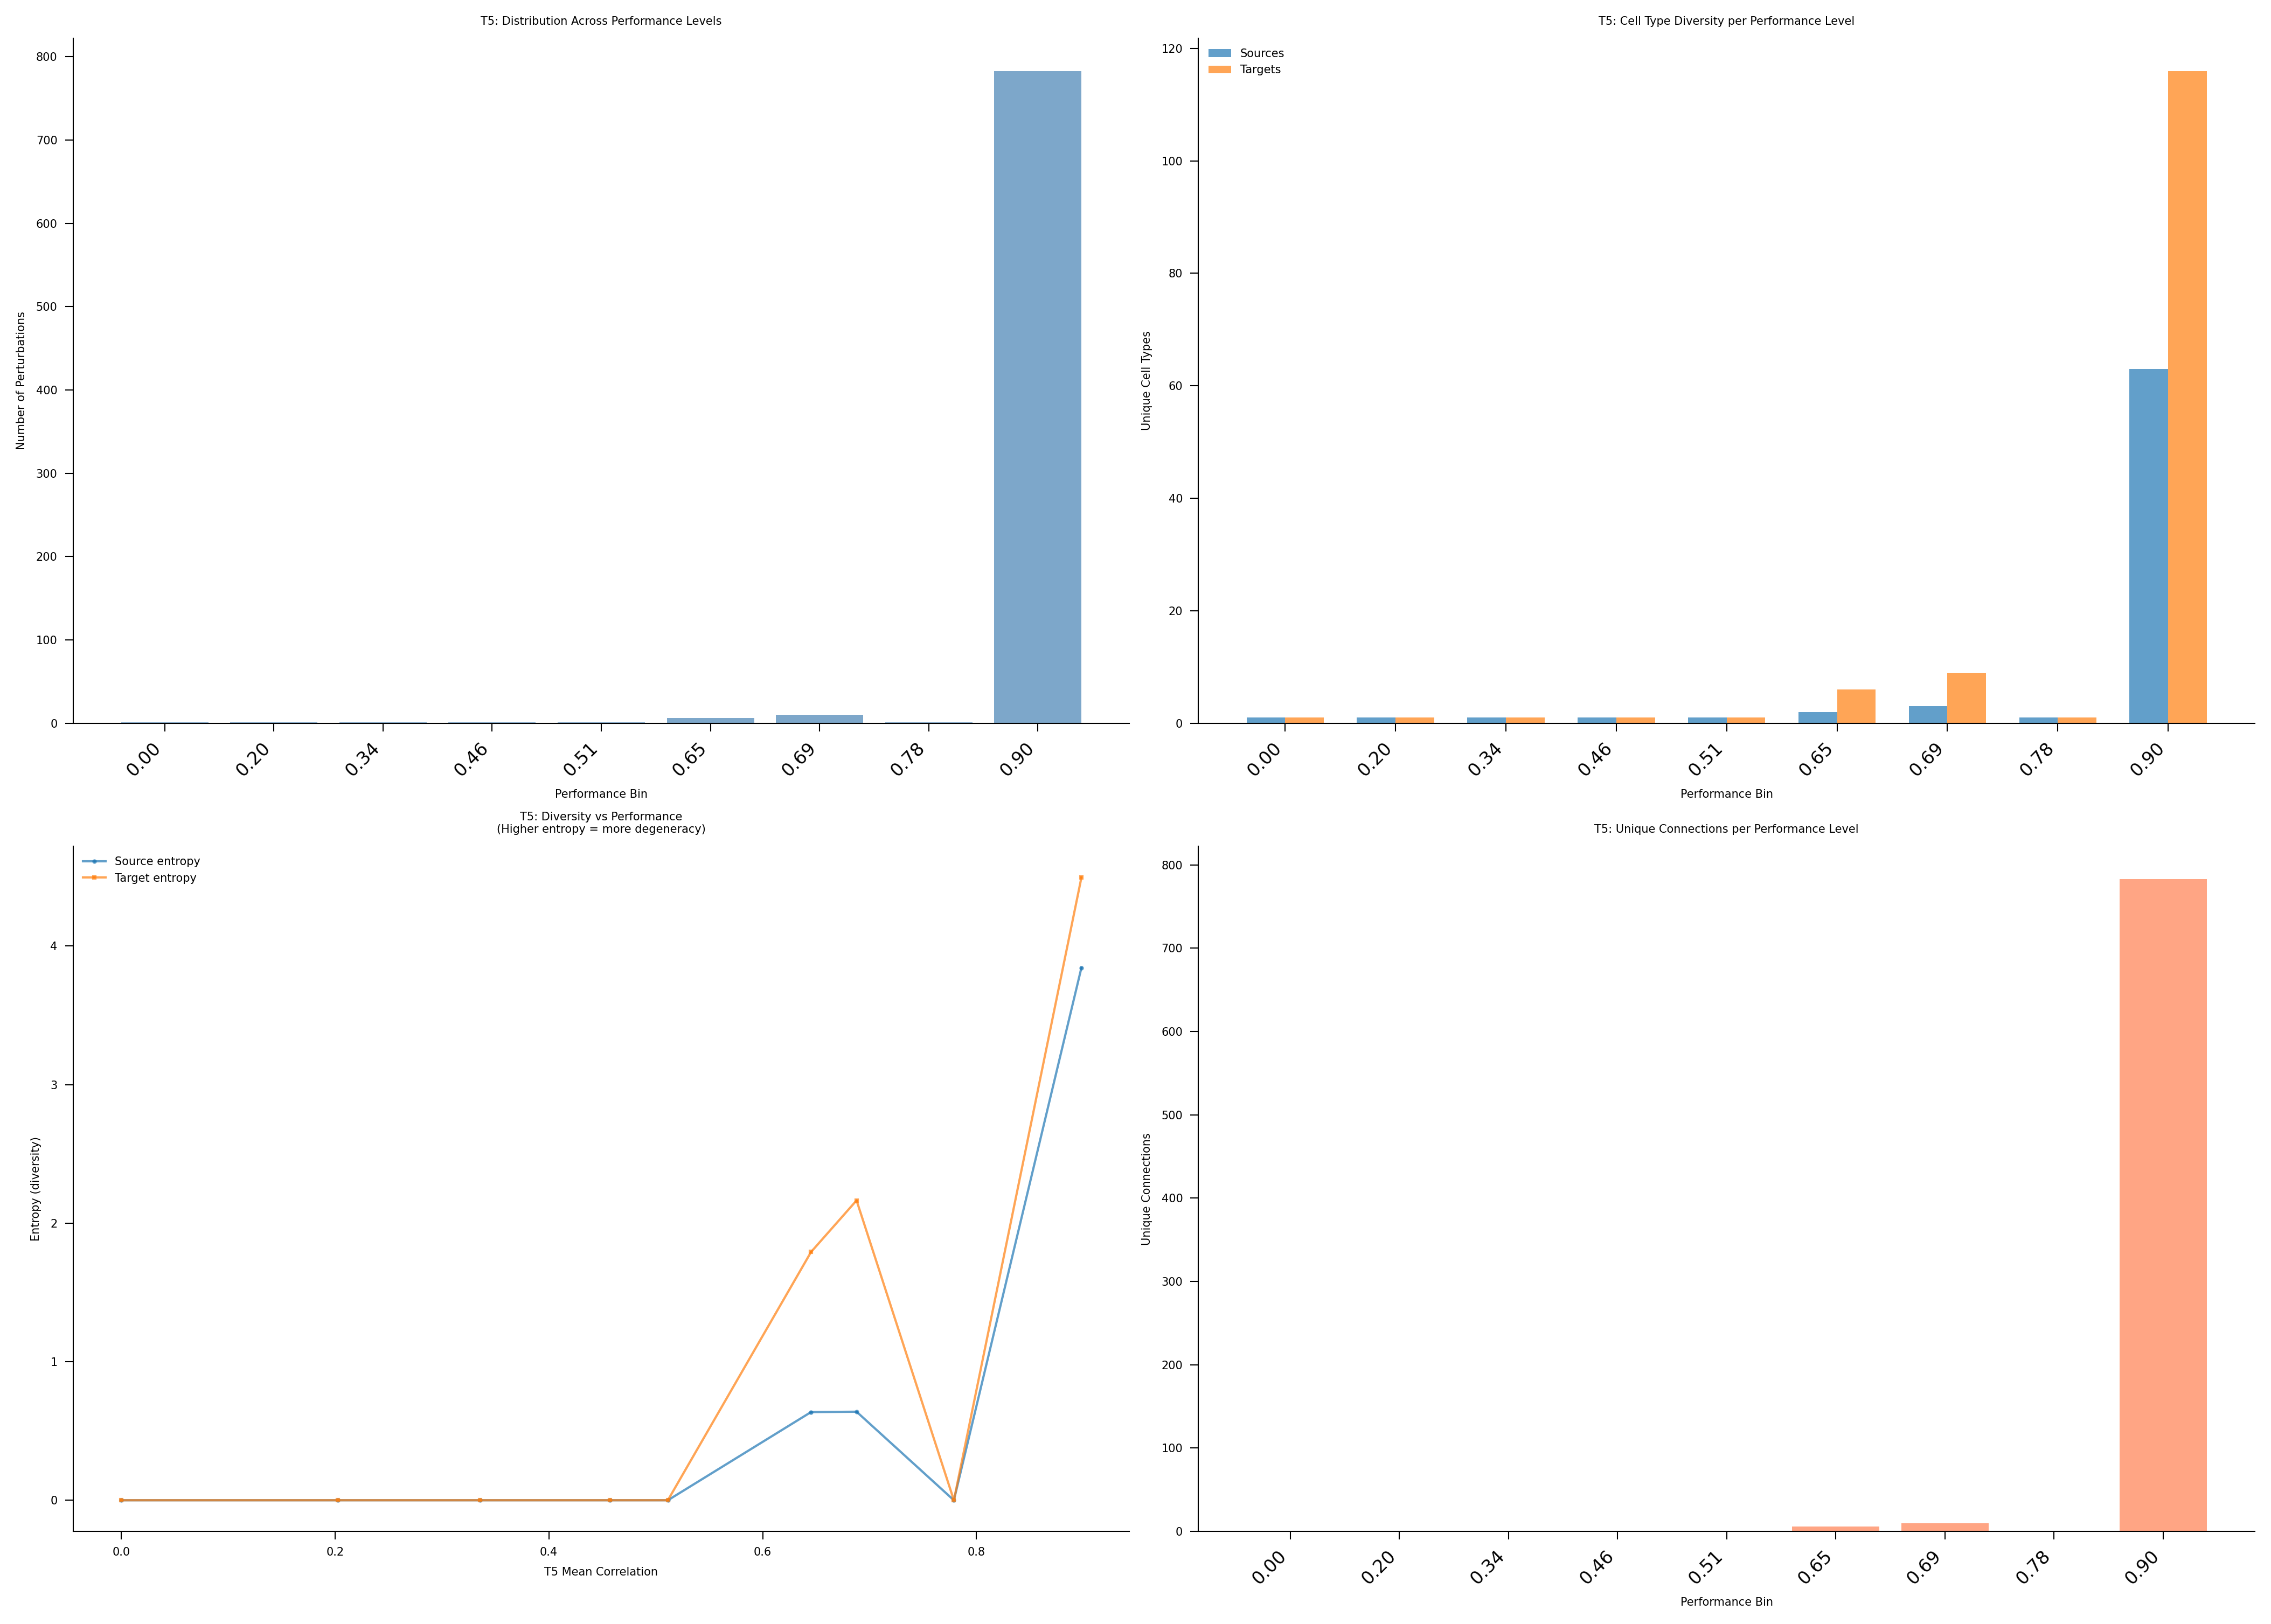

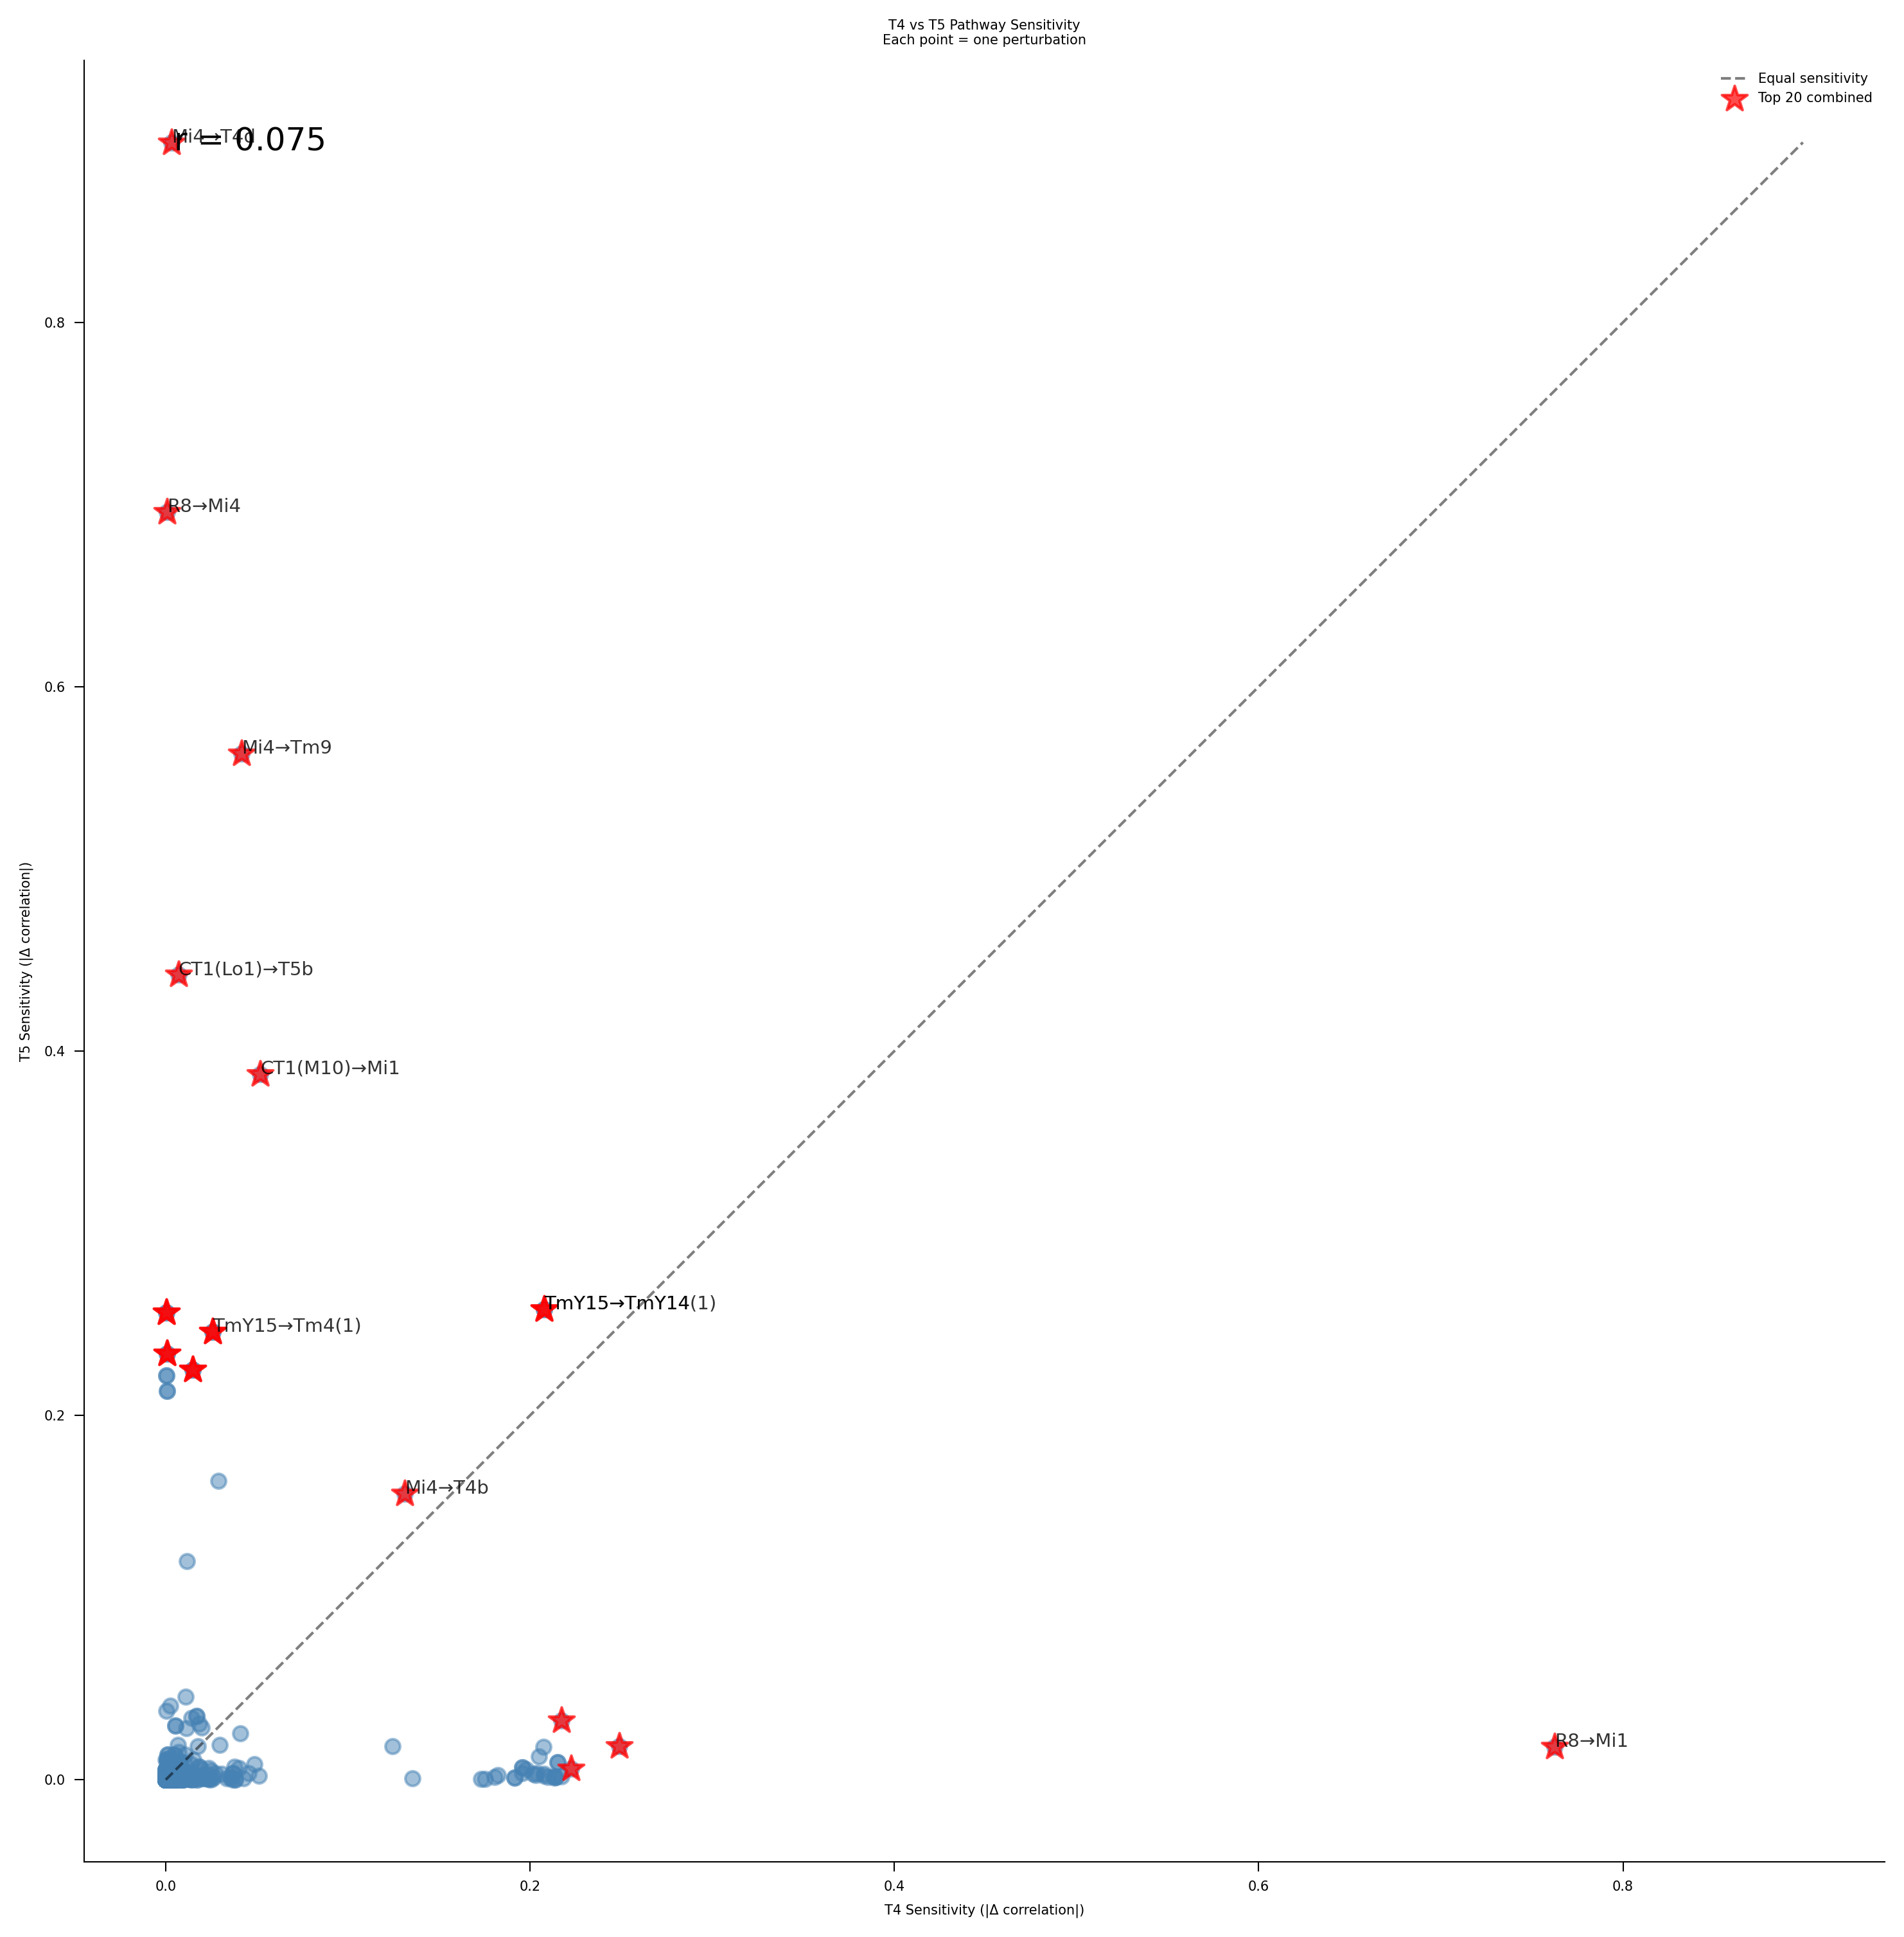

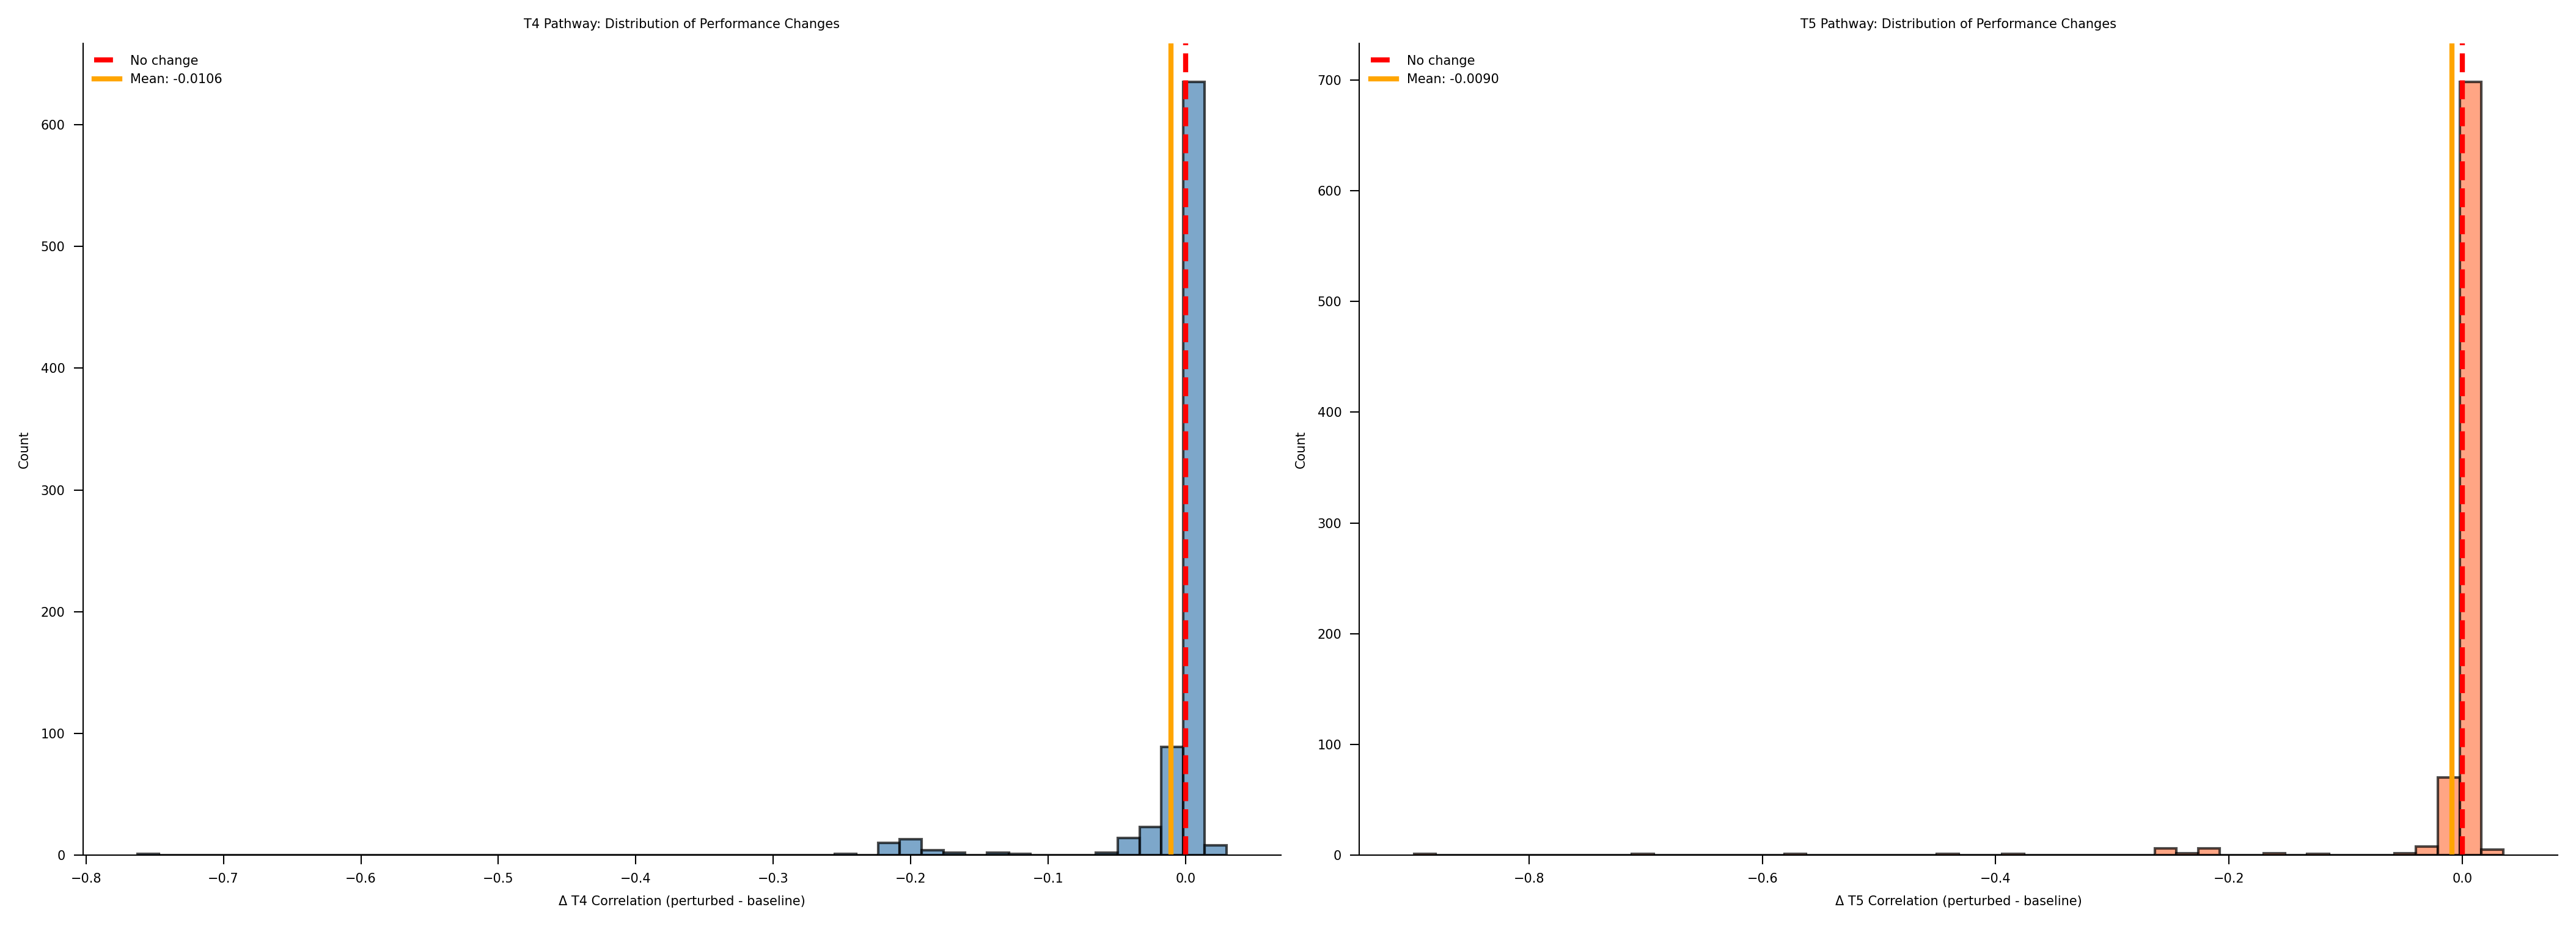

In [3]:
"""
Degeneracy Landscape Analysis for FlyVis Pairwise Perturbations

Analyzes the fitness landscape of motion detection circuits by examining 
how pairwise connection perturbations affect T4 and T5 tuning curve fidelity.

Approach #3: Local Sensitivity + Global Degeneracy Analysis
- Keeps T4 (ON pathway) and T5 (OFF pathway) analyses separate
- Aggregates across subtypes within each pathway
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
import seaborn as sns
from scipy import stats
from scipy.spatial.distance import pdist, squareform
from typing import Dict, List, Tuple, Optional
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# CONFIGURATION - UPDATE THESE PATHS
# =============================================================================

DATA_PATH = r"C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\data\flyvis_data"
PAIRWISE_PERT_PATH = f"{DATA_PATH}/moving_edge/pair-wise-pert-moving-edge-results"
ORIGINAL_NETWORK_PATH = f"{DATA_PATH}/moving_edge/mv_edge_original_network.csv"
OUTPUT_PATH = r"C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\analysis_outputs"

# Cell type definitions
T4_CELLS = ['T4a', 'T4b', 'T4c', 'T4d']
T5_CELLS = ['T5a', 'T5b', 'T5c', 'T5d']

# Metric columns
T4_METRIC = 'tc_correlation_intensity1'  # For T4 cells
T5_METRIC = 'tc_correlation_intensity0'  # For T5 cells


# =============================================================================
# DATA LOADING
# =============================================================================

def load_original_network(path: str) -> pd.DataFrame:
    """Load the baseline/original network results."""
    df = pd.read_csv(path)
    print(f"Loaded original network: {df.shape[0]} cell types")
    return df


def load_single_perturbation(filepath: Path) -> Optional[pd.DataFrame]:
    """Load a single perturbation result file."""
    try:
        df = pd.read_csv(filepath)
        df['cell_type'] = df['cell_type'].str.strip()
        return df
    except Exception as e:
        print(f"Error loading {filepath}: {e}")
        return None


def parse_perturbation_filename(filename: str) -> Dict[str, str]:
    """
    Parse perturbation filename to extract source and target.
    Expected format: {src}_{target}.csv
    """
    stem = Path(filename).stem  # Remove .csv
    parts = stem.split('_')
    
    if len(parts) >= 2:
        source = parts[0]
        target = '_'.join(parts[1:])  # In case target has underscores
        return {'source': source, 'target': target}
    else:
        return {'source': stem, 'target': 'unknown'}


def load_all_perturbations(pert_dir: str) -> pd.DataFrame:
    """
    Load all perturbation results and compute aggregate metrics.
    
    Returns DataFrame with one row per perturbation containing:
    - source, target cell types
    - T4 mean correlation (across T4a-d)
    - T5 mean correlation (across T5a-d)
    - Individual cell type correlations
    """
    pert_path = Path(pert_dir)
    csv_files = list(pert_path.glob("*.csv"))
    print(f"Found {len(csv_files)} perturbation files")
    
    results = []
    
    for filepath in csv_files:
        df = load_single_perturbation(filepath)
        if df is None:
            continue
        
        # Parse filename for perturbation identity
        pert_info = parse_perturbation_filename(filepath.name)
        
        # Extract metrics for each cell type
        row = {
            'perturbation': filepath.stem,
            'source': pert_info['source'],
            'target': pert_info['target'],
            'filepath': str(filepath)
        }
        
        # Get T4 correlations (using intensity1)
        t4_corrs = []
        for cell in T4_CELLS:
            cell_data = df[df['cell_type'] == cell]
            if len(cell_data) > 0:
                corr = cell_data[T4_METRIC].values[0]
                row[f'{cell}_corr'] = corr
                t4_corrs.append(corr)
            else:
                row[f'{cell}_corr'] = np.nan
        
        # Get T5 correlations (using intensity0)
        t5_corrs = []
        for cell in T5_CELLS:
            cell_data = df[df['cell_type'] == cell]
            if len(cell_data) > 0:
                corr = cell_data[T5_METRIC].values[0]
                row[f'{cell}_corr'] = corr
                t5_corrs.append(corr)
            else:
                row[f'{cell}_corr'] = np.nan
        
        # Compute aggregates
        row['T4_mean_corr'] = np.nanmean(t4_corrs) if t4_corrs else np.nan
        row['T5_mean_corr'] = np.nanmean(t5_corrs) if t5_corrs else np.nan
        row['T4_min_corr'] = np.nanmin(t4_corrs) if t4_corrs else np.nan
        row['T5_min_corr'] = np.nanmin(t5_corrs) if t5_corrs else np.nan
        
        results.append(row)
    
    results_df = pd.DataFrame(results)
    print(f"Loaded {len(results_df)} perturbations successfully")
    
    return results_df


# =============================================================================
# BASELINE COMPUTATION
# =============================================================================

def compute_baseline_metrics(original_df: pd.DataFrame) -> Dict[str, float]:
    """Compute baseline performance metrics from original network."""
    original_df['cell_type'] = original_df['cell_type'].str.strip()
    
    baseline = {}
    
    # T4 baseline
    t4_corrs = []
    for cell in T4_CELLS:
        cell_data = original_df[original_df['cell_type'] == cell]
        if len(cell_data) > 0:
            corr = cell_data[T4_METRIC].values[0]
            baseline[f'{cell}_corr'] = corr
            t4_corrs.append(corr)
    
    # T5 baseline
    t5_corrs = []
    for cell in T5_CELLS:
        cell_data = original_df[original_df['cell_type'] == cell]
        if len(cell_data) > 0:
            corr = cell_data[T5_METRIC].values[0]
            baseline[f'{cell}_corr'] = corr
            t5_corrs.append(corr)
    
    baseline['T4_mean_corr'] = np.mean(t4_corrs)
    baseline['T5_mean_corr'] = np.mean(t5_corrs)
    baseline['T4_min_corr'] = np.min(t4_corrs)
    baseline['T5_min_corr'] = np.min(t5_corrs)
    
    print(f"Baseline T4 mean correlation: {baseline['T4_mean_corr']:.4f}")
    print(f"Baseline T5 mean correlation: {baseline['T5_mean_corr']:.4f}")
    
    return baseline


# =============================================================================
# SENSITIVITY ANALYSIS
# =============================================================================

def compute_sensitivity(pert_df: pd.DataFrame, baseline: Dict[str, float]) -> pd.DataFrame:
    """
    Compute sensitivity metrics for each perturbation.
    
    Sensitivity = change from baseline (can be positive or negative)
    """
    df = pert_df.copy()
    
    # Delta from baseline (signed)
    df['T4_delta'] = df['T4_mean_corr'] - baseline['T4_mean_corr']
    df['T5_delta'] = df['T5_mean_corr'] - baseline['T5_mean_corr']
    
    # Absolute sensitivity
    df['T4_sensitivity'] = np.abs(df['T4_delta'])
    df['T5_sensitivity'] = np.abs(df['T5_delta'])
    
    # Combined sensitivity (average of T4 and T5)
    df['combined_sensitivity'] = (df['T4_sensitivity'] + df['T5_sensitivity']) / 2
    
    # Per-subtype deltas
    for cell in T4_CELLS + T5_CELLS:
        if f'{cell}_corr' in df.columns and f'{cell}_corr' in baseline:
            df[f'{cell}_delta'] = df[f'{cell}_corr'] - baseline[f'{cell}_corr']
            df[f'{cell}_sensitivity'] = np.abs(df[f'{cell}_delta'])
    
    # Add baseline values for reference
    df['T4_baseline'] = baseline['T4_mean_corr']
    df['T5_baseline'] = baseline['T5_mean_corr']
    
    return df


def compute_cell_type_sensitivity(sensitivity_df: pd.DataFrame, 
                                   pathway: str = 'T4') -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Aggregate sensitivity by cell type (as source and as target).
    
    Args:
        sensitivity_df: DataFrame with sensitivity values
        pathway: 'T4' or 'T5' to select which sensitivity metric
    """
    metric = f'{pathway}_sensitivity'
    delta_metric = f'{pathway}_delta'
    
    # By source
    source_agg = sensitivity_df.groupby('source').agg({
        metric: ['mean', 'std', 'max', 'count'],
        delta_metric: ['mean', 'std']
    }).round(4)
    source_agg.columns = ['_'.join(col) for col in source_agg.columns]
    source_agg = source_agg.rename(columns={
        f'{metric}_mean': 'sensitivity_mean',
        f'{metric}_std': 'sensitivity_std', 
        f'{metric}_max': 'sensitivity_max',
        f'{metric}_count': 'n_perturbations',
        f'{delta_metric}_mean': 'delta_mean',
        f'{delta_metric}_std': 'delta_std'
    })
    
    # By target
    target_agg = sensitivity_df.groupby('target').agg({
        metric: ['mean', 'std', 'max', 'count'],
        delta_metric: ['mean', 'std']
    }).round(4)
    target_agg.columns = ['_'.join(col) for col in target_agg.columns]
    target_agg = target_agg.rename(columns={
        f'{metric}_mean': 'sensitivity_mean',
        f'{metric}_std': 'sensitivity_std',
        f'{metric}_max': 'sensitivity_max', 
        f'{metric}_count': 'n_perturbations',
        f'{delta_metric}_mean': 'delta_mean',
        f'{delta_metric}_std': 'delta_std'
    })
    
    return source_agg, target_agg


# =============================================================================
# DEGENERACY ANALYSIS
# =============================================================================

def compute_degeneracy_metrics(sensitivity_df: pd.DataFrame,
                                pathway: str = 'T4',
                                threshold: float = 0.05) -> Dict:
    """
    Compute degeneracy metrics for a pathway.
    
    Degeneracy = multiple configurations achieving similar performance
    
    Args:
        threshold: max sensitivity to consider "acceptable" (minimal impact)
    """
    metric = f'{pathway}_sensitivity'
    corr_metric = f'{pathway}_mean_corr'
    
    # Acceptable perturbations (low sensitivity)
    acceptable = sensitivity_df[sensitivity_df[metric] < threshold]
    n_acceptable = len(acceptable)
    frac_acceptable = n_acceptable / len(sensitivity_df) if len(sensitivity_df) > 0 else 0
    
    # Diversity of acceptable perturbations
    if len(acceptable) > 0:
        n_unique_sources = acceptable['source'].nunique()
        n_unique_targets = acceptable['target'].nunique()
        connections = set(zip(acceptable['source'], acceptable['target']))
        n_unique_connections = len(connections)
    else:
        n_unique_sources = n_unique_targets = n_unique_connections = 0
    
    # Performance distribution
    perf_mean = sensitivity_df[corr_metric].mean()
    perf_std = sensitivity_df[corr_metric].std()
    
    return {
        'pathway': pathway,
        'threshold': threshold,
        'n_total': len(sensitivity_df),
        'n_acceptable': n_acceptable,
        'frac_acceptable': frac_acceptable,
        'n_unique_sources_acceptable': n_unique_sources,
        'n_unique_targets_acceptable': n_unique_targets,
        'n_unique_connections_acceptable': n_unique_connections,
        'performance_mean': perf_mean,
        'performance_std': perf_std
    }


def compute_iso_performance_sets(sensitivity_df: pd.DataFrame,
                                  pathway: str = 'T4',
                                  n_bins: int = 10) -> pd.DataFrame:
    """
    Group perturbations into iso-performance sets and analyze diversity.
    """
    corr_metric = f'{pathway}_mean_corr'
    
    df = sensitivity_df.copy()
    df['perf_bin'] = pd.cut(df[corr_metric], bins=n_bins)
    
    iso_sets = []
    for bin_label, group in df.groupby('perf_bin', observed=True):
        if len(group) == 0:
            continue
        
        connections = list(zip(group['source'], group['target']))
        
        iso_sets.append({
            'performance_bin': str(bin_label),
            'bin_left': bin_label.left if hasattr(bin_label, 'left') else np.nan,
            'bin_right': bin_label.right if hasattr(bin_label, 'right') else np.nan,
            'n_perturbations': len(group),
            'mean_performance': group[corr_metric].mean(),
            'n_unique_sources': group['source'].nunique(),
            'n_unique_targets': group['target'].nunique(),
            'n_unique_connections': len(set(connections)),
            'source_entropy': stats.entropy(group['source'].value_counts()) if len(group) > 1 else 0,
            'target_entropy': stats.entropy(group['target'].value_counts()) if len(group) > 1 else 0,
        })
    
    return pd.DataFrame(iso_sets).sort_values('mean_performance')


def compute_landscape_roughness(sensitivity_df: pd.DataFrame,
                                 pathway: str = 'T4') -> Dict:
    """
    Compute fitness landscape roughness.
    
    Roughness = how much performance varies between "neighboring" perturbations
    (perturbations sharing a source or target cell type)
    
    Low roughness = smooth landscape (similar perturbations → similar effects)
    High roughness = rugged landscape (small changes → large swings)
    """
    corr_metric = f'{pathway}_mean_corr'
    
    perturbations = sensitivity_df['perturbation'].tolist()
    performances = sensitivity_df[corr_metric].tolist()
    sources = sensitivity_df['source'].tolist()
    targets = sensitivity_df['target'].tolist()
    
    # Find neighbor pairs (share source OR target)
    neighbor_diffs = []
    neighbor_pairs = []
    
    for i in range(len(perturbations)):
        for j in range(i + 1, len(perturbations)):
            shared_source = sources[i] == sources[j]
            shared_target = targets[i] == targets[j]
            
            if shared_source or shared_target:
                diff = abs(performances[i] - performances[j])
                neighbor_diffs.append(diff)
                neighbor_pairs.append((perturbations[i], perturbations[j], 
                                       'source' if shared_source else 'target'))
    
    if len(neighbor_diffs) > 0:
        roughness = np.mean(neighbor_diffs)
        roughness_std = np.std(neighbor_diffs)
    else:
        roughness = roughness_std = np.nan
    
    # Compare to random (all pairs)
    all_diffs = pdist(np.array(performances).reshape(-1, 1))
    random_roughness = np.mean(all_diffs) if len(all_diffs) > 0 else np.nan
    
    # Ratio < 1 means smoother than random
    roughness_ratio = roughness / random_roughness if random_roughness > 0 else np.nan
    
    return {
        'pathway': pathway,
        'roughness': roughness,
        'roughness_std': roughness_std,
        'random_roughness': random_roughness,
        'roughness_ratio': roughness_ratio,
        'n_neighbor_pairs': len(neighbor_diffs),
        'interpretation': 'smoother than random' if roughness_ratio < 1 else 'rougher than random'
    }


# =============================================================================
# VISUALIZATION
# =============================================================================

def plot_sensitivity_heatmap(sensitivity_df: pd.DataFrame, 
                              pathway: str = 'T4',
                              output_path: Optional[str] = None):
    """Heatmap of sensitivity (source × target)."""
    metric = f'{pathway}_sensitivity'
    
    pivot = sensitivity_df.pivot_table(
        index='source',
        columns='target', 
        values=metric,
        aggfunc='mean'
    )
    
    fig, ax = plt.subplots(figsize=(16, 12))
    sns.heatmap(pivot, annot=False, cmap='RdYlGn_r', ax=ax,
                cbar_kws={'label': f'{pathway} Sensitivity (|Δ correlation|)'})
    ax.set_title(f'{pathway} Pathway: Connection Sensitivity Matrix\n(Higher = More Critical)')
    ax.set_xlabel('Target Cell Type')
    ax.set_ylabel('Source Cell Type')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {output_path}")
    
    return fig, ax


def plot_sensitivity_heatmap_annotated(sensitivity_df: pd.DataFrame,
                                        pathway: str = 'T4', 
                                        top_n: int = 30,
                                        output_path: Optional[str] = None):
    """Heatmap showing only top N most sensitive connections."""
    metric = f'{pathway}_sensitivity'
    
    # Get top N
    top_df = sensitivity_df.nlargest(top_n, metric)
    
    pivot = top_df.pivot_table(
        index='source',
        columns='target',
        values=metric,
        aggfunc='mean'
    )
    
    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(pivot, annot=True, fmt='.3f', cmap='RdYlGn_r', ax=ax,
                cbar_kws={'label': f'{pathway} Sensitivity'})
    ax.set_title(f'{pathway} Pathway: Top {top_n} Most Sensitive Connections')
    ax.set_xlabel('Target Cell Type')
    ax.set_ylabel('Source Cell Type')
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {output_path}")
    
    return fig, ax


def plot_cell_type_sensitivity_bars(source_sens: pd.DataFrame,
                                     target_sens: pd.DataFrame,
                                     pathway: str = 'T4',
                                     output_path: Optional[str] = None):
    """Bar plots of sensitivity by cell type."""
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # Source (outgoing connections)
    ax1 = axes[0]
    src_sorted = source_sens.sort_values('sensitivity_mean', ascending=True)
    colors = plt.cm.RdYlGn_r(
        (src_sorted['sensitivity_mean'] - src_sorted['sensitivity_mean'].min()) /
        (src_sorted['sensitivity_mean'].max() - src_sorted['sensitivity_mean'].min() + 1e-10)
    )
    bars1 = ax1.barh(range(len(src_sorted)), src_sorted['sensitivity_mean'], 
                     xerr=src_sorted['sensitivity_std'], color=colors, capsize=2, alpha=0.8)
    ax1.set_yticks(range(len(src_sorted)))
    ax1.set_yticklabels(src_sorted.index, fontsize=8)
    ax1.set_xlabel(f'Mean {pathway} Sensitivity')
    ax1.set_title(f'{pathway}: Sensitivity by Source\n(Outgoing Connections)')
    ax1.axvline(src_sorted['sensitivity_mean'].median(), color='gray', 
                linestyle='--', alpha=0.7, label='Median')
    ax1.legend()
    
    # Target (incoming connections)
    ax2 = axes[1]
    tgt_sorted = target_sens.sort_values('sensitivity_mean', ascending=True)
    colors = plt.cm.RdYlGn_r(
        (tgt_sorted['sensitivity_mean'] - tgt_sorted['sensitivity_mean'].min()) /
        (tgt_sorted['sensitivity_mean'].max() - tgt_sorted['sensitivity_mean'].min() + 1e-10)
    )
    bars2 = ax2.barh(range(len(tgt_sorted)), tgt_sorted['sensitivity_mean'],
                     xerr=tgt_sorted['sensitivity_std'], color=colors, capsize=2, alpha=0.8)
    ax2.set_yticks(range(len(tgt_sorted)))
    ax2.set_yticklabels(tgt_sorted.index, fontsize=8)
    ax2.set_xlabel(f'Mean {pathway} Sensitivity')
    ax2.set_title(f'{pathway}: Sensitivity by Target\n(Incoming Connections)')
    ax2.axvline(tgt_sorted['sensitivity_mean'].median(), color='gray',
                linestyle='--', alpha=0.7, label='Median')
    ax2.legend()
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {output_path}")
    
    return fig, axes


def plot_t4_vs_t5_sensitivity(sensitivity_df: pd.DataFrame,
                               output_path: Optional[str] = None):
    """Scatter plot comparing T4 vs T5 sensitivity for each perturbation."""
    fig, ax = plt.subplots(figsize=(10, 10))
    
    scatter = ax.scatter(sensitivity_df['T4_sensitivity'], 
                         sensitivity_df['T5_sensitivity'],
                         alpha=0.5, s=30, c='steelblue')
    
    # Add diagonal
    max_val = max(sensitivity_df['T4_sensitivity'].max(), 
                  sensitivity_df['T5_sensitivity'].max())
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, label='Equal sensitivity')
    
    # Highlight top combined sensitivity
    top_n = 20
    top_combined = sensitivity_df.nlargest(top_n, 'combined_sensitivity')
    ax.scatter(top_combined['T4_sensitivity'], top_combined['T5_sensitivity'],
               c='red', s=100, alpha=0.7, marker='*', label=f'Top {top_n} combined')
    
    # Annotate top hits
    for _, row in top_combined.head(10).iterrows():
        ax.annotate(f"{row['source']}→{row['target']}", 
                    (row['T4_sensitivity'], row['T5_sensitivity']),
                    fontsize=7, alpha=0.8)
    
    ax.set_xlabel('T4 Sensitivity (|Δ correlation|)')
    ax.set_ylabel('T5 Sensitivity (|Δ correlation|)')
    ax.set_title('T4 vs T5 Pathway Sensitivity\nEach point = one perturbation')
    ax.legend()
    ax.set_aspect('equal')
    
    # Add correlation
    corr = sensitivity_df['T4_sensitivity'].corr(sensitivity_df['T5_sensitivity'])
    ax.text(0.05, 0.95, f'r = {corr:.3f}', transform=ax.transAxes, fontsize=12)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {output_path}")
    
    return fig, ax


def plot_degeneracy_landscape(sensitivity_df: pd.DataFrame,
                               pathway: str = 'T4',
                               output_path: Optional[str] = None):
    """1D fitness landscape sorted by performance."""
    corr_metric = f'{pathway}_mean_corr'
    sens_metric = f'{pathway}_sensitivity'
    baseline_metric = f'{pathway}_baseline'
    
    sorted_df = sensitivity_df.sort_values(corr_metric).reset_index(drop=True)
    
    fig, ax = plt.subplots(figsize=(14, 6))
    
    # Color by sensitivity
    colors = plt.cm.RdYlGn_r(
        (sorted_df[sens_metric] - sorted_df[sens_metric].min()) /
        (sorted_df[sens_metric].max() - sorted_df[sens_metric].min() + 1e-10)
    )
    
    ax.scatter(range(len(sorted_df)), sorted_df[corr_metric], 
               c=colors, s=30, alpha=0.7)
    
    # Baseline line
    baseline = sorted_df[baseline_metric].iloc[0]
    ax.axhline(baseline, color='black', linestyle='--', linewidth=2, 
               label=f'Baseline ({baseline:.3f})')
    
    # Threshold bands
    ax.axhspan(baseline - 0.05, baseline + 0.05, alpha=0.1, color='green',
               label='±0.05 from baseline')
    
    ax.set_xlabel('Perturbation (sorted by performance)')
    ax.set_ylabel(f'{pathway} Mean Correlation')
    ax.set_title(f'{pathway} Fitness Landscape\n(Color = sensitivity, sorted by performance)')
    ax.legend()
    
    # Colorbar
    sm = plt.cm.ScalarMappable(cmap='RdYlGn_r',
                                norm=plt.Normalize(vmin=sorted_df[sens_metric].min(),
                                                   vmax=sorted_df[sens_metric].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax)
    cbar.set_label('Sensitivity')
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {output_path}")
    
    return fig, ax


def plot_iso_performance_diversity(iso_perf_df: pd.DataFrame,
                                    pathway: str = 'T4',
                                    output_path: Optional[str] = None):
    """Plot diversity within iso-performance bins."""
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    x = range(len(iso_perf_df))
    
    # Top left: distribution of perturbations
    ax1 = axes[0, 0]
    ax1.bar(x, iso_perf_df['n_perturbations'], color='steelblue', alpha=0.7)
    ax1.set_xlabel('Performance Bin')
    ax1.set_ylabel('Number of Perturbations')
    ax1.set_title(f'{pathway}: Distribution Across Performance Levels')
    ax1.set_xticks(x)
    ax1.set_xticklabels([f'{p:.2f}' for p in iso_perf_df['mean_performance']], 
                        rotation=45, ha='right', fontsize=8)
    
    # Top right: unique cell types per bin
    ax2 = axes[0, 1]
    width = 0.35
    ax2.bar([i - width/2 for i in x], iso_perf_df['n_unique_sources'], 
            width, label='Sources', alpha=0.7)
    ax2.bar([i + width/2 for i in x], iso_perf_df['n_unique_targets'],
            width, label='Targets', alpha=0.7)
    ax2.set_xlabel('Performance Bin')
    ax2.set_ylabel('Unique Cell Types')
    ax2.set_title(f'{pathway}: Cell Type Diversity per Performance Level')
    ax2.set_xticks(x)
    ax2.set_xticklabels([f'{p:.2f}' for p in iso_perf_df['mean_performance']],
                        rotation=45, ha='right', fontsize=8)
    ax2.legend()
    
    # Bottom left: entropy
    ax3 = axes[1, 0]
    ax3.plot(iso_perf_df['mean_performance'], iso_perf_df['source_entropy'], 
             'o-', label='Source entropy', alpha=0.7)
    ax3.plot(iso_perf_df['mean_performance'], iso_perf_df['target_entropy'],
             's-', label='Target entropy', alpha=0.7)
    ax3.set_xlabel(f'{pathway} Mean Correlation')
    ax3.set_ylabel('Entropy (diversity)')
    ax3.set_title(f'{pathway}: Diversity vs Performance\n(Higher entropy = more degeneracy)')
    ax3.legend()
    
    # Bottom right: unique connections
    ax4 = axes[1, 1]
    ax4.bar(x, iso_perf_df['n_unique_connections'], color='coral', alpha=0.7)
    ax4.set_xlabel('Performance Bin')
    ax4.set_ylabel('Unique Connections')
    ax4.set_title(f'{pathway}: Unique Connections per Performance Level')
    ax4.set_xticks(x)
    ax4.set_xticklabels([f'{p:.2f}' for p in iso_perf_df['mean_performance']],
                        rotation=45, ha='right', fontsize=8)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {output_path}")
    
    return fig, axes


def plot_delta_distribution(sensitivity_df: pd.DataFrame,
                             output_path: Optional[str] = None):
    """Distribution of delta (signed change) for T4 and T5."""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # T4 delta
    ax1 = axes[0]
    ax1.hist(sensitivity_df['T4_delta'], bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    ax1.axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
    ax1.axvline(sensitivity_df['T4_delta'].mean(), color='orange', linestyle='-', 
                linewidth=2, label=f'Mean: {sensitivity_df["T4_delta"].mean():.4f}')
    ax1.set_xlabel('Δ T4 Correlation (perturbed - baseline)')
    ax1.set_ylabel('Count')
    ax1.set_title('T4 Pathway: Distribution of Performance Changes')
    ax1.legend()
    
    # T5 delta
    ax2 = axes[1]
    ax2.hist(sensitivity_df['T5_delta'], bins=50, alpha=0.7, color='coral', edgecolor='black')
    ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
    ax2.axvline(sensitivity_df['T5_delta'].mean(), color='orange', linestyle='-',
                linewidth=2, label=f'Mean: {sensitivity_df["T5_delta"].mean():.4f}')
    ax2.set_xlabel('Δ T5 Correlation (perturbed - baseline)')
    ax2.set_ylabel('Count')
    ax2.set_title('T5 Pathway: Distribution of Performance Changes')
    ax2.legend()
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        print(f"Saved: {output_path}")
    
    return fig, axes


# =============================================================================
# MAIN ANALYSIS PIPELINE
# =============================================================================

def run_full_analysis(original_path: str = ORIGINAL_NETWORK_PATH,
                      pert_path: str = PAIRWISE_PERT_PATH,
                      output_dir: str = OUTPUT_PATH):
    """Run the complete degeneracy landscape analysis."""
    
    print("=" * 70)
    print("DEGENERACY LANDSCAPE ANALYSIS")
    print("FlyVis Motion Detection Circuit")
    print("=" * 70)
    
    # Create output directory
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)
    
    # 1. Load data
    print("\n[1/7] Loading data...")
    original_df = load_original_network(original_path)
    pert_df = load_all_perturbations(pert_path)
    
    # 2. Compute baseline
    print("\n[2/7] Computing baseline metrics...")
    baseline = compute_baseline_metrics(original_df)
    
    # 3. Compute sensitivity
    print("\n[3/7] Computing sensitivity for all perturbations...")
    sensitivity_df = compute_sensitivity(pert_df, baseline)
    
    print(f"\nTop 10 most sensitive perturbations (T4):")
    print(sensitivity_df.nlargest(10, 'T4_sensitivity')[
        ['perturbation', 'source', 'target', 'T4_mean_corr', 'T4_delta', 'T4_sensitivity']
    ].to_string())
    
    print(f"\nTop 10 most sensitive perturbations (T5):")
    print(sensitivity_df.nlargest(10, 'T5_sensitivity')[
        ['perturbation', 'source', 'target', 'T5_mean_corr', 'T5_delta', 'T5_sensitivity']
    ].to_string())
    
    # 4. Cell type aggregation
    print("\n[4/7] Aggregating by cell type...")
    t4_source_sens, t4_target_sens = compute_cell_type_sensitivity(sensitivity_df, 'T4')
    t5_source_sens, t5_target_sens = compute_cell_type_sensitivity(sensitivity_df, 'T5')
    
    print("\nT4 - Top 10 sensitive sources (outgoing):")
    print(t4_source_sens.nlargest(10, 'sensitivity_mean').to_string())
    
    print("\nT5 - Top 10 sensitive sources (outgoing):")
    print(t5_source_sens.nlargest(10, 'sensitivity_mean').to_string())
    
    # 5. Degeneracy metrics
    print("\n[5/7] Computing degeneracy metrics...")
    for threshold in [0.02, 0.05, 0.1]:
        t4_deg = compute_degeneracy_metrics(sensitivity_df, 'T4', threshold)
        t5_deg = compute_degeneracy_metrics(sensitivity_df, 'T5', threshold)
        print(f"\nThreshold = {threshold}:")
        print(f"  T4: {t4_deg['n_acceptable']}/{t4_deg['n_total']} ({t4_deg['frac_acceptable']:.1%}) acceptable")
        print(f"  T5: {t5_deg['n_acceptable']}/{t5_deg['n_total']} ({t5_deg['frac_acceptable']:.1%}) acceptable")
    
    # Iso-performance sets
    t4_iso = compute_iso_performance_sets(sensitivity_df, 'T4')
    t5_iso = compute_iso_performance_sets(sensitivity_df, 'T5')
    
    # 6. Landscape roughness
    print("\n[6/7] Computing landscape roughness...")
    t4_roughness = compute_landscape_roughness(sensitivity_df, 'T4')
    t5_roughness = compute_landscape_roughness(sensitivity_df, 'T5')
    
    print(f"\nT4 Landscape:")
    print(f"  Roughness: {t4_roughness['roughness']:.4f} (random: {t4_roughness['random_roughness']:.4f})")
    print(f"  Ratio: {t4_roughness['roughness_ratio']:.3f} → {t4_roughness['interpretation']}")
    
    print(f"\nT5 Landscape:")
    print(f"  Roughness: {t5_roughness['roughness']:.4f} (random: {t5_roughness['random_roughness']:.4f})")
    print(f"  Ratio: {t5_roughness['roughness_ratio']:.3f} → {t5_roughness['interpretation']}")
    
    # 7. Generate visualizations
    print("\n[7/7] Generating visualizations...")
    
    # T4 plots
    plot_sensitivity_heatmap(sensitivity_df, 'T4', output_dir / "T4_sensitivity_heatmap.png")
    plot_sensitivity_heatmap_annotated(sensitivity_df, 'T4', 30, output_dir / "T4_top30_heatmap.png")
    plot_cell_type_sensitivity_bars(t4_source_sens, t4_target_sens, 'T4', 
                                     output_dir / "T4_celltype_sensitivity.png")
    plot_degeneracy_landscape(sensitivity_df, 'T4', output_dir / "T4_fitness_landscape.png")
    plot_iso_performance_diversity(t4_iso, 'T4', output_dir / "T4_iso_performance.png")
    
    # T5 plots
    plot_sensitivity_heatmap(sensitivity_df, 'T5', output_dir / "T5_sensitivity_heatmap.png")
    plot_sensitivity_heatmap_annotated(sensitivity_df, 'T5', 30, output_dir / "T5_top30_heatmap.png")
    plot_cell_type_sensitivity_bars(t5_source_sens, t5_target_sens, 'T5',
                                     output_dir / "T5_celltype_sensitivity.png")
    plot_degeneracy_landscape(sensitivity_df, 'T5', output_dir / "T5_fitness_landscape.png")
    plot_iso_performance_diversity(t5_iso, 'T5', output_dir / "T5_iso_performance.png")
    
    # Combined plots
    plot_t4_vs_t5_sensitivity(sensitivity_df, output_dir / "T4_vs_T5_sensitivity.png")
    plot_delta_distribution(sensitivity_df, output_dir / "delta_distributions.png")
    
    # Save data
    print("\nSaving results...")
    sensitivity_df.to_csv(output_dir / "all_perturbation_sensitivity.csv", index=False)
    t4_source_sens.to_csv(output_dir / "T4_source_sensitivity.csv")
    t4_target_sens.to_csv(output_dir / "T4_target_sensitivity.csv")
    t5_source_sens.to_csv(output_dir / "T5_source_sensitivity.csv")
    t5_target_sens.to_csv(output_dir / "T5_target_sensitivity.csv")
    t4_iso.to_csv(output_dir / "T4_iso_performance.csv", index=False)
    t5_iso.to_csv(output_dir / "T5_iso_performance.csv", index=False)
    
    # Summary
    summary = {
        'n_perturbations': len(sensitivity_df),
        'n_unique_sources': sensitivity_df['source'].nunique(),
        'n_unique_targets': sensitivity_df['target'].nunique(),
        'T4_baseline': baseline['T4_mean_corr'],
        'T5_baseline': baseline['T5_mean_corr'],
        'T4_mean_sensitivity': sensitivity_df['T4_sensitivity'].mean(),
        'T5_mean_sensitivity': sensitivity_df['T5_sensitivity'].mean(),
        'T4_roughness_ratio': t4_roughness['roughness_ratio'],
        'T5_roughness_ratio': t5_roughness['roughness_ratio'],
    }
    pd.Series(summary).to_csv(output_dir / "analysis_summary.csv")
    
    print("\n" + "=" * 70)
    print("ANALYSIS COMPLETE")
    print(f"Results saved to: {output_dir}")
    print("=" * 70)
    
    return {
        'sensitivity_df': sensitivity_df,
        'baseline': baseline,
        't4_source_sens': t4_source_sens,
        't4_target_sens': t4_target_sens,
        't5_source_sens': t5_source_sens,
        't5_target_sens': t5_target_sens,
        't4_iso': t4_iso,
        't5_iso': t5_iso,
        't4_roughness': t4_roughness,
        't5_roughness': t5_roughness,
        'summary': summary
    }


# =============================================================================
# RUN
# =============================================================================

if __name__ == "__main__":
    results = run_full_analysis()

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional

# Set global font sizes for better readability
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 18,
    'axes.labelsize': 16,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 12,
})

In [21]:
def plot_cell_type_sensitivity_bars(source_sens: pd.DataFrame,
                                     target_sens: pd.DataFrame,
                                     pathway: str = 'T4',
                                     top_n: Optional[int] = None,
                                     output_path: Optional[str] = None):
    """
    Bar plots of sensitivity by cell type.
    
    Args:
        source_sens: DataFrame with sensitivity aggregated by source cell type
        target_sens: DataFrame with sensitivity aggregated by target cell type
        pathway: 'T4' or 'T5'
        top_n: If set, only show top N most sensitive cell types
        output_path: Path to save figure
    """
    fig, axes = plt.subplots(1, 2, figsize=(18, 10))
    
    # Sort by sensitivity
    src_sorted = source_sens.sort_values('sensitivity_mean', ascending=True)
    tgt_sorted = target_sens.sort_values('sensitivity_mean', ascending=True)
    
    # Optionally limit to top N
    if top_n is not None:
        src_sorted = src_sorted.tail(top_n)
        tgt_sorted = tgt_sorted.tail(top_n)
    
    # --- Source plot (left) ---
    ax1 = axes[0]
    
    # Color gradient based on sensitivity
    src_norm = (src_sorted['sensitivity_mean'] - src_sorted['sensitivity_mean'].min()) / \
               (src_sorted['sensitivity_mean'].max() - src_sorted['sensitivity_mean'].min() + 1e-10)
    colors_src = plt.cm.viridis(src_norm)
    
    y_pos = np.arange(len(src_sorted))
    bars1 = ax1.barh(y_pos, src_sorted['sensitivity_mean'],
                     xerr=src_sorted['sensitivity_std'], 
                     color=colors_src, capsize=3, alpha=0.85,
                     error_kw={'linewidth': 1.5})
    
    ax1.set_yticks(y_pos)
    ax1.set_yticklabels(src_sorted.index, fontsize=11)
    ax1.set_xlabel(f'Mean Impact', fontsize=16, fontweight='bold')
    ax1.set_title(f'Perturbation Impact on {pathway} by Source Cell Type', fontsize=18, fontweight='bold')
    
    
    
    # Clean up spines
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # --- Target plot (right) ---
    ax2 = axes[1]
    
    # Color gradient
    tgt_norm = (tgt_sorted['sensitivity_mean'] - tgt_sorted['sensitivity_mean'].min()) / \
               (tgt_sorted['sensitivity_mean'].max() - tgt_sorted['sensitivity_mean'].min() + 1e-10)
    colors_tgt = plt.cm.viridis(tgt_norm)
    
    y_pos = np.arange(len(tgt_sorted))
    bars2 = ax2.barh(y_pos, tgt_sorted['sensitivity_mean'],
                     xerr=tgt_sorted['sensitivity_std'],
                     color=colors_tgt, capsize=3, alpha=0.85,
                     error_kw={'linewidth': 1.5})
    
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(tgt_sorted.index, fontsize=11)
    ax2.set_xlabel(f'Mean Impact', fontsize=16, fontweight='bold')
    ax2.set_title(f'Perturbation Impact on {pathway} by Target Cell Type', fontsize=18, fontweight='bold')
    
    
    # Clean up spines
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=200, bbox_inches='tight', facecolor='white')
        print(f"Saved: {output_path}")
    
    plt.show()
    return fig, axes


In [33]:
def plot_t4_vs_t5_sensitivity(sensitivity_df: pd.DataFrame,
                               top_n_annotate: int = 10,
                               top_n_highlight: int = 10,
                               output_path: Optional[str] = None):
    """
    Scatter plot comparing T4 vs T5 sensitivity for each perturbation.
    
    Args:
        sensitivity_df: DataFrame with T4_sensitivity and T5_sensitivity columns
        top_n_annotate: Number of top perturbations to label
        top_n_highlight: Number of top perturbations to highlight with stars
        output_path: Path to save figure
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Main scatter
    scatter = ax.scatter(
        sensitivity_df['T4_sensitivity'], 
        sensitivity_df['T5_sensitivity'],
        alpha=0.4, 
        s=60, 
        c='steelblue',
        edgecolors='white',
        linewidths=0.5
    )
    
    # Diagonal line (equal sensitivity)
    max_val = max(sensitivity_df['T4_sensitivity'].max(), 
                  sensitivity_df['T5_sensitivity'].max()) * 1.05
    ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.5, linewidth=2)
    
    # Highlight top combined sensitivity
    top_combined = sensitivity_df.nlargest(top_n_highlight, 'combined_sensitivity')
    ax.scatter(
        top_combined['T4_sensitivity'], 
        top_combined['T5_sensitivity'],
        c='red', 
        s=200, 
        alpha=0.8, 
        marker='*',
        edgecolors='darkred',
        linewidths=1,
        zorder=5
    )
    
    # Annotate top hits
    for _, row in top_combined.head(top_n_annotate).iterrows():
        label = f"{row['source']}→{row['target']}"
        ax.annotate(
            label,
            (row['T4_sensitivity'], row['T5_sensitivity']),
            fontsize=11,
            fontweight='bold',
            alpha=0.9,
            xytext=(8, 8),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7, edgecolor='gray'),
            arrowprops=dict(arrowstyle='-', color='gray', alpha=0.5)
        )
    
    # Labels and title
    ax.set_xlabel('Perturbation Impact on T4', fontsize=20, fontweight='bold')
    ax.set_ylabel('Perturbation Impact on T5', fontsize=20, fontweight='bold')
    ax.set_title('Effect of Perturbations on T4 vs T5', fontsize=22, fontweight='bold')
    
    # Tick sizes
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Legend
    ax.legend(fontsize=14, loc='upper left', framealpha=0.9)
    
    # Equal aspect ratio
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(0, max_val)
    ax.set_ylim(0, max_val)
    
    # Add correlation coefficient
    corr = sensitivity_df['T4_sensitivity'].corr(sensitivity_df['T5_sensitivity'])
    ax.text(
        0.95, 0.05, 
        #f'r = {corr:.3f}', 
        transform=ax.transAxes, 
        fontsize=18,
        fontweight='bold',
        ha='right',
        va='bottom',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8, edgecolor='black')
    )
    
    # Add quadrant labels
    mid_x = max_val / 2
    mid_y = max_val / 2
    
    ax.text(max_val * 0.75, max_val * 0.15, 'T4-specific', fontsize=12, 
            ha='center', va='center', alpha=0.5, style='italic')
    ax.text(max_val * 0.15, max_val * 0.75, 'T5-specific', fontsize=12,
            ha='center', va='center', alpha=0.5, style='italic')
    ax.text(max_val * 0.85, max_val * 0.85, 'T4 and T5 are equally impacted', fontsize=12,
            ha='center', va='center', alpha=0.5, style='italic')
    
    # Clean up spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Grid for readability
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=200, bbox_inches='tight', facecolor='white')
        print(f"Saved: {output_path}")
    
    plt.show()
    return fig, ax


In [8]:
def plot_t4_vs_t5_delta(sensitivity_df: pd.DataFrame,
                         top_n_annotate: int = 10,
                         output_path: Optional[str] = None):
    """
    Alternative: Scatter plot of SIGNED delta (not absolute sensitivity).
    
    This shows whether perturbations increase or decrease performance,
    and whether T4 and T5 move in the same direction.
    """
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Main scatter
    scatter = ax.scatter(
        sensitivity_df['T4_delta'], 
        sensitivity_df['T5_delta'],
        alpha=0.4, 
        s=60, 
        c='steelblue',
        edgecolors='white',
        linewidths=0.5
    )
    
    # Reference lines at zero
    ax.axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    ax.axvline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
    
    # Diagonal
    max_abs = max(
        abs(sensitivity_df['T4_delta'].min()), abs(sensitivity_df['T4_delta'].max()),
        abs(sensitivity_df['T5_delta'].min()), abs(sensitivity_df['T5_delta'].max())
    ) * 1.1
    ax.plot([-max_abs, max_abs], [-max_abs, max_abs], 'k--', alpha=0.3, linewidth=2)
    
    # Highlight extreme perturbations
    sensitivity_df['abs_combined_delta'] = np.abs(sensitivity_df['T4_delta']) + np.abs(sensitivity_df['T5_delta'])
    top_extreme = sensitivity_df.nlargest(top_n_annotate, 'abs_combined_delta')
    
    ax.scatter(
        top_extreme['T4_delta'], 
        top_extreme['T5_delta'],
        c='red', 
        s=200, 
        alpha=0.8, 
        marker='*',
        edgecolors='darkred',
        linewidths=1,
        zorder=5
    )
    
    # Annotate
    for _, row in top_extreme.iterrows():
        label = f"{row['source']}→{row['target']}"
        ax.annotate(
            label,
            (row['T4_delta'], row['T5_delta']),
            fontsize=10,
            fontweight='bold',
            xytext=(8, 8),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
        )
    
    # Labels
    ax.set_xlabel('Δ T4 Correlation', fontsize=20, fontweight='bold')
    ax.set_ylabel('Δ T5 Correlation', fontsize=20, fontweight='bold')
    ax.set_title('Change in T4 vs T5 Performance', fontsize=22, fontweight='bold')
    
    ax.tick_params(axis='both', which='major', labelsize=14)
    
    # Quadrant labels
    ax.text(max_abs * 0.6, max_abs * 0.6, 'Both improve', fontsize=12, 
            ha='center', alpha=0.5, style='italic')
    ax.text(-max_abs * 0.6, -max_abs * 0.6, 'Both worsen', fontsize=12,
            ha='center', alpha=0.5, style='italic')
    ax.text(max_abs * 0.6, -max_abs * 0.6, 'T4↑ T5↓', fontsize=12,
            ha='center', alpha=0.5, style='italic')
    ax.text(-max_abs * 0.6, max_abs * 0.6, 'T4↓ T5↑', fontsize=12,
            ha='center', alpha=0.5, style='italic')
    
    # Correlation
    corr = sensitivity_df['T4_delta'].corr(sensitivity_df['T5_delta'])
    ax.text(
        0.95, 0.05, 
        f'r = {corr:.3f}', 
        transform=ax.transAxes, 
        fontsize=18,
        fontweight='bold',
        ha='right',
        bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.8)
    )
    
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(-max_abs, max_abs)
    ax.set_ylim(-max_abs, max_abs)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    if output_path:
        plt.savefig(output_path, dpi=200, bbox_inches='tight', facecolor='white')
        print(f"Saved: {output_path}")
    
    plt.show()
    return fig, ax

Saved: C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\analysis_outputs/T4_celltype_sensitivity_improved.png


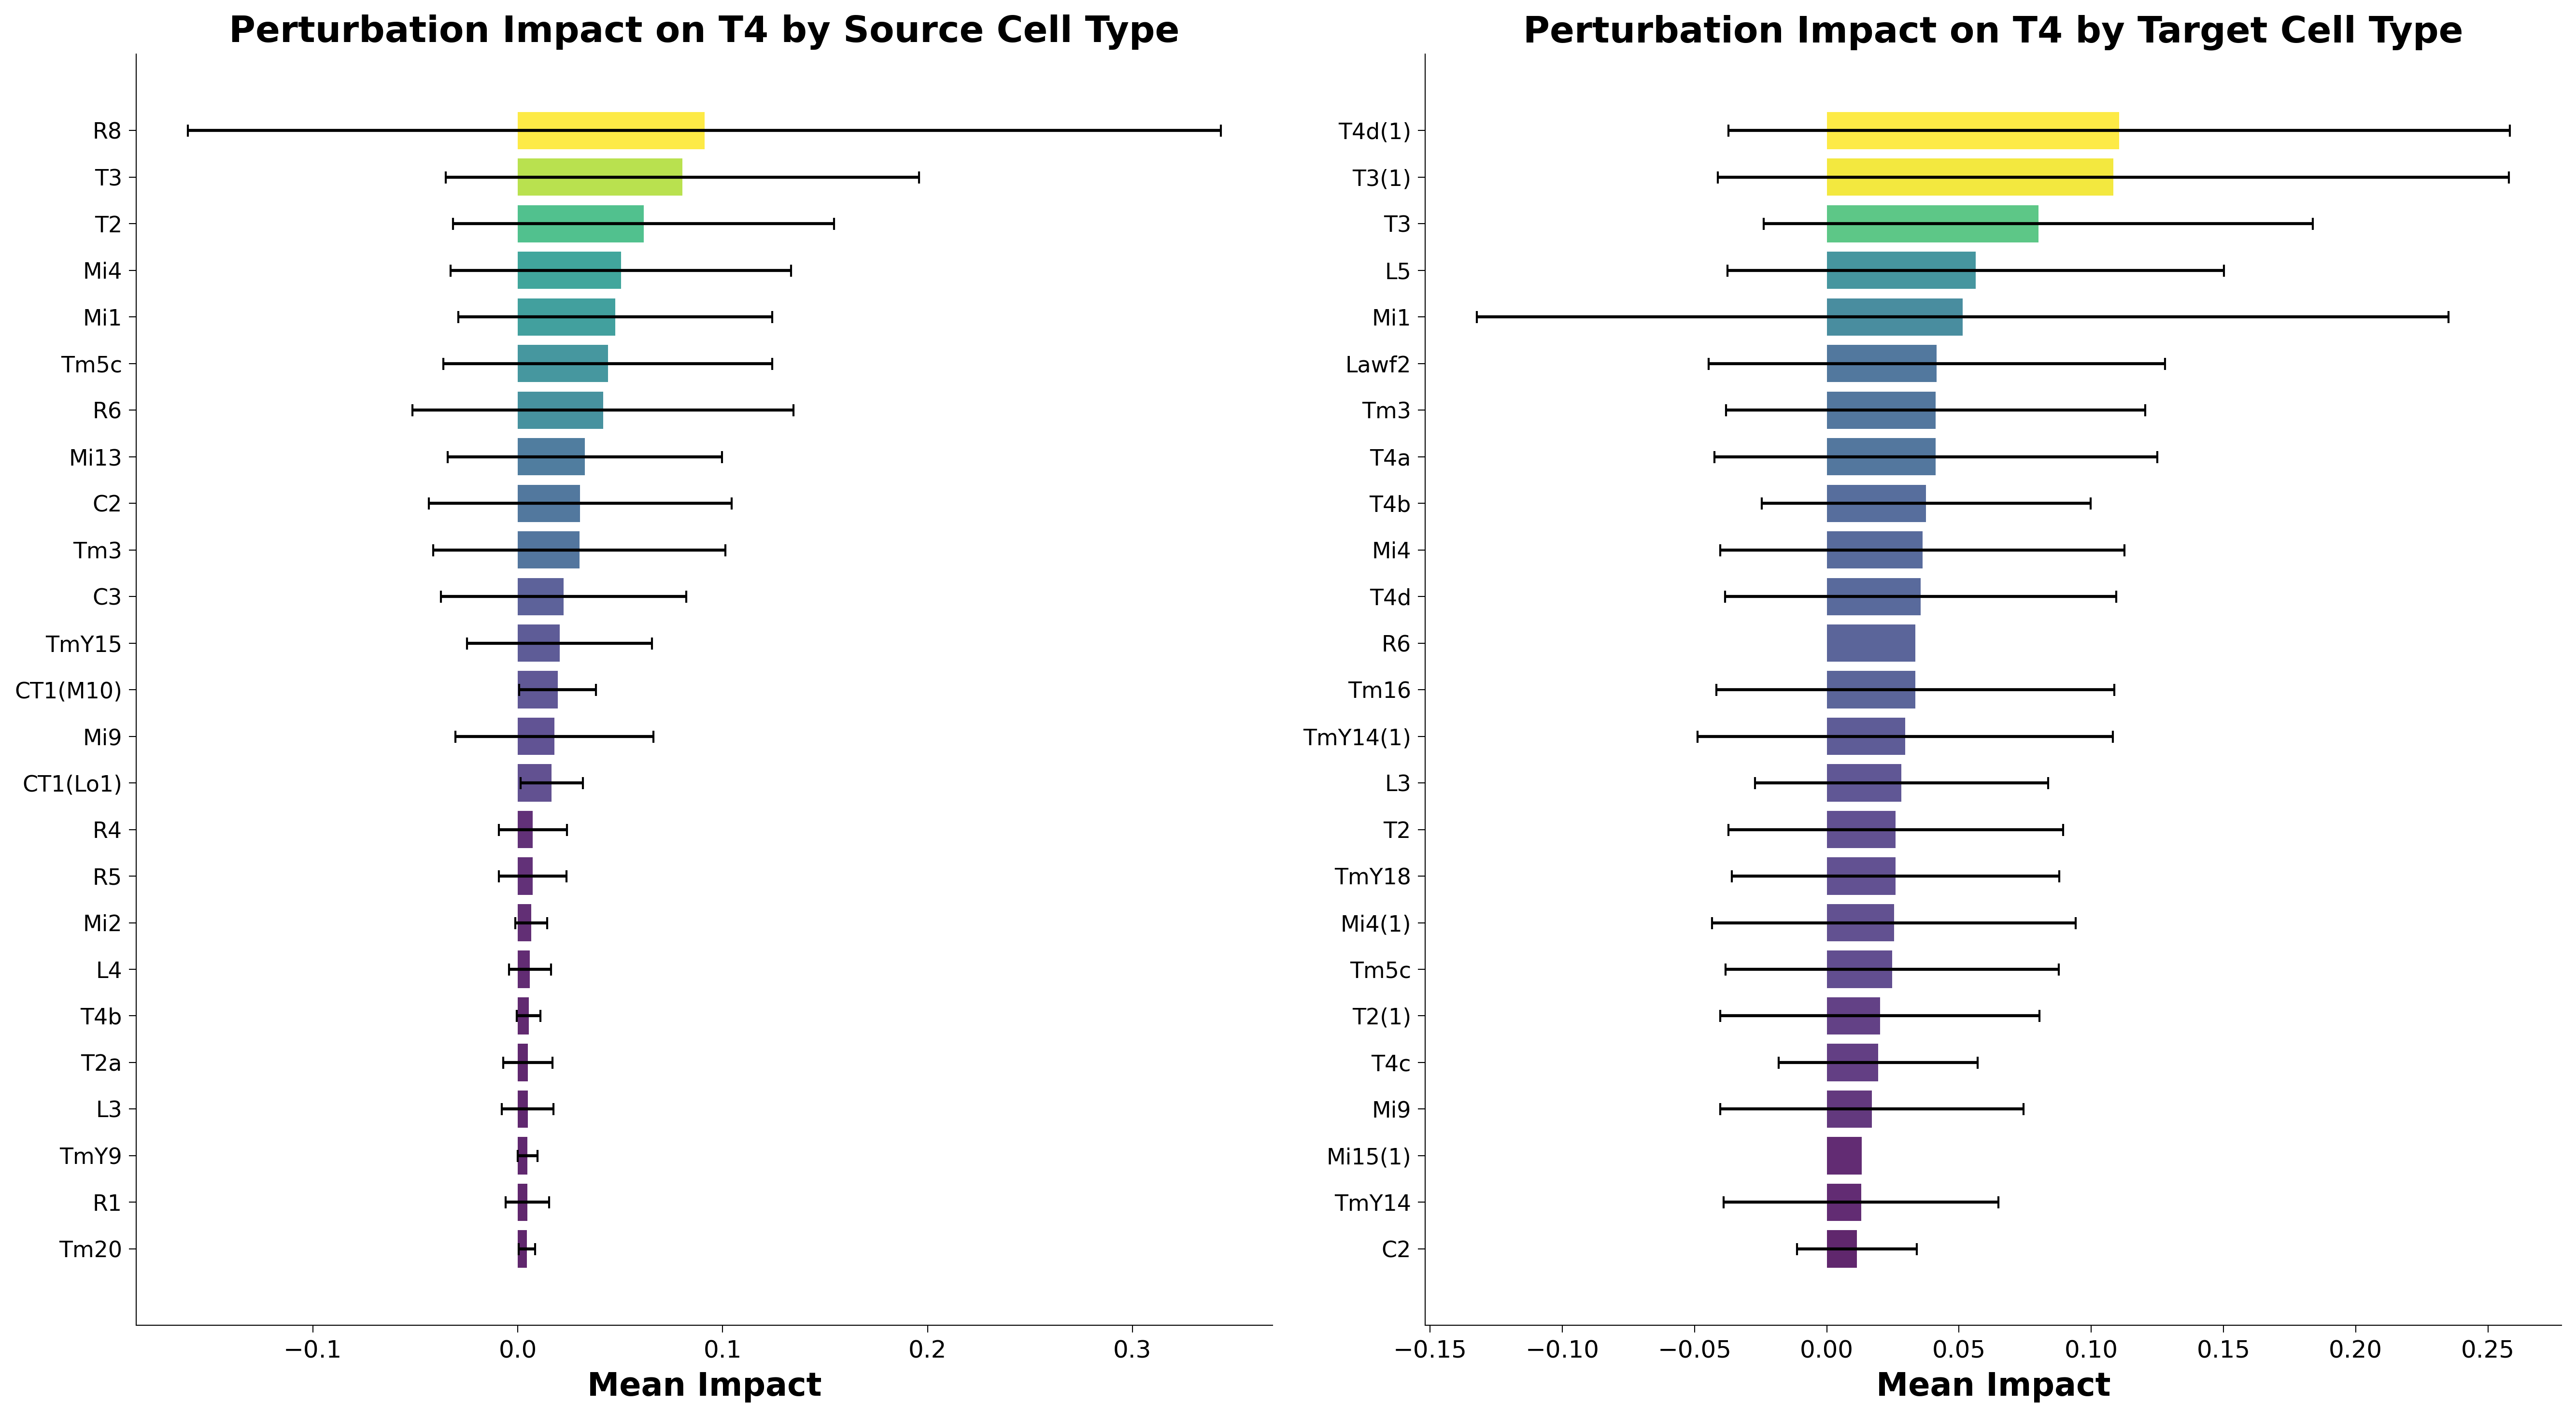

Saved: C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\analysis_outputs/T5_celltype_sensitivity_improved.png


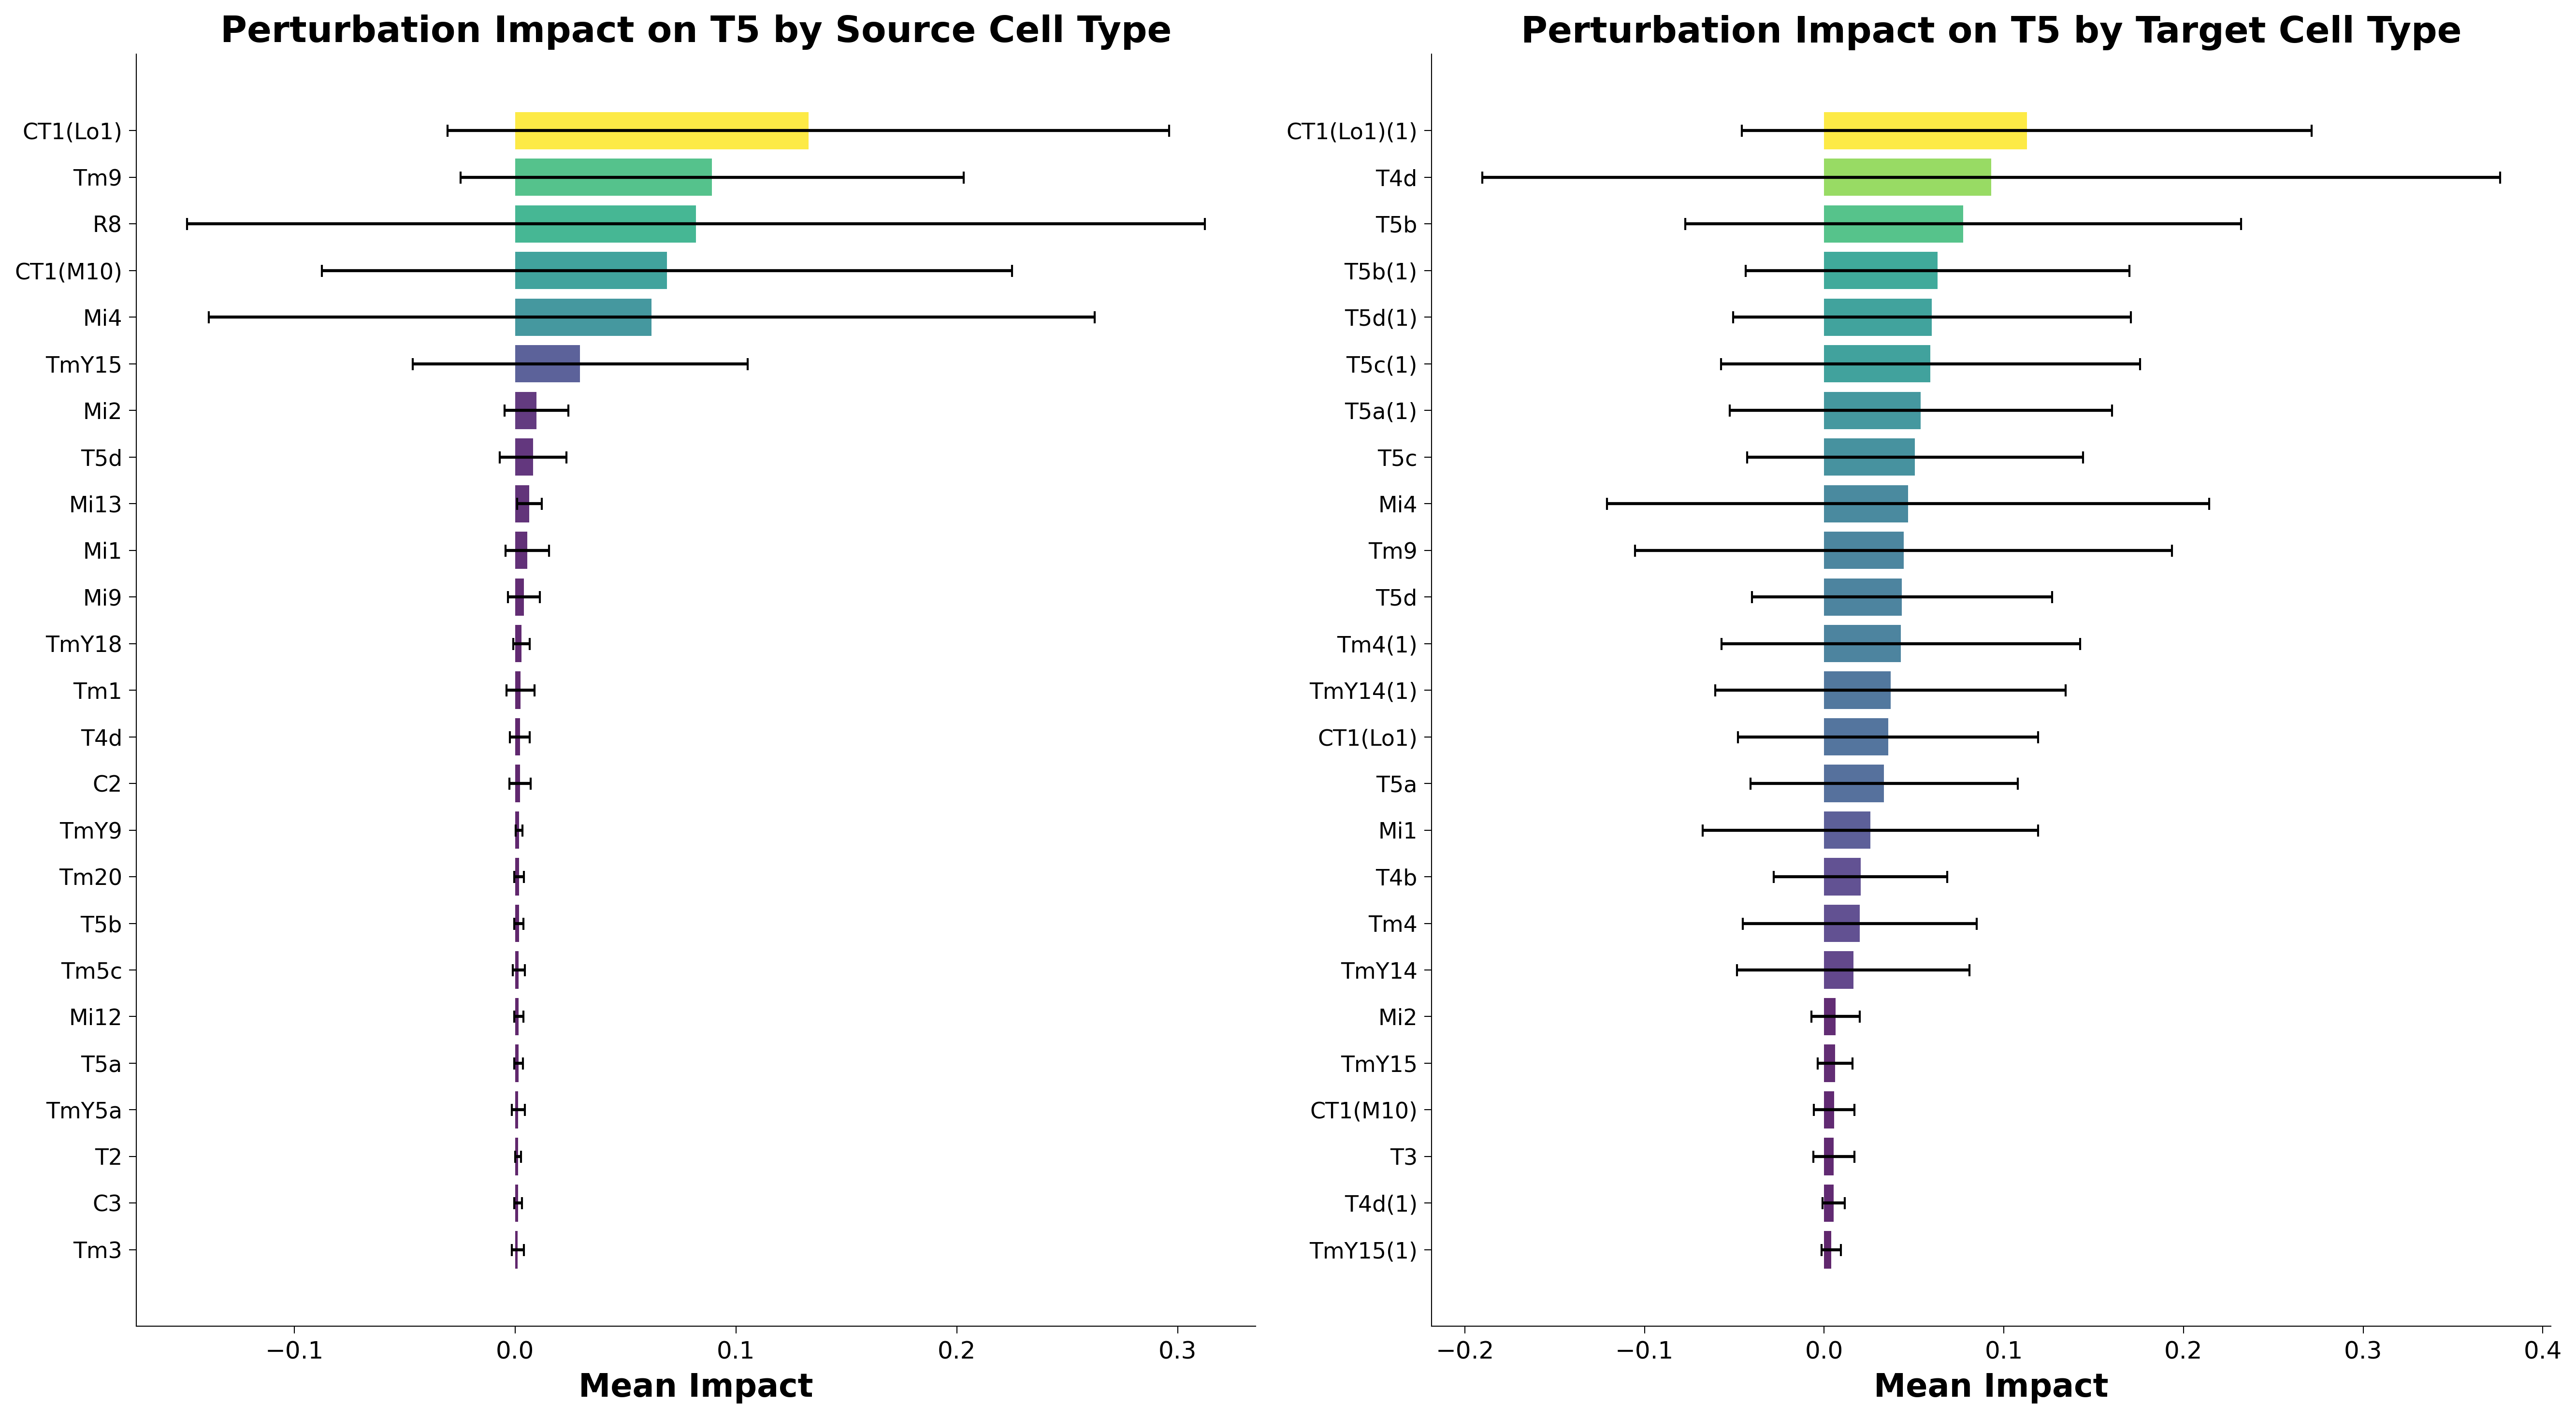

TypeError: Axes.text() missing 1 required positional argument: 's'

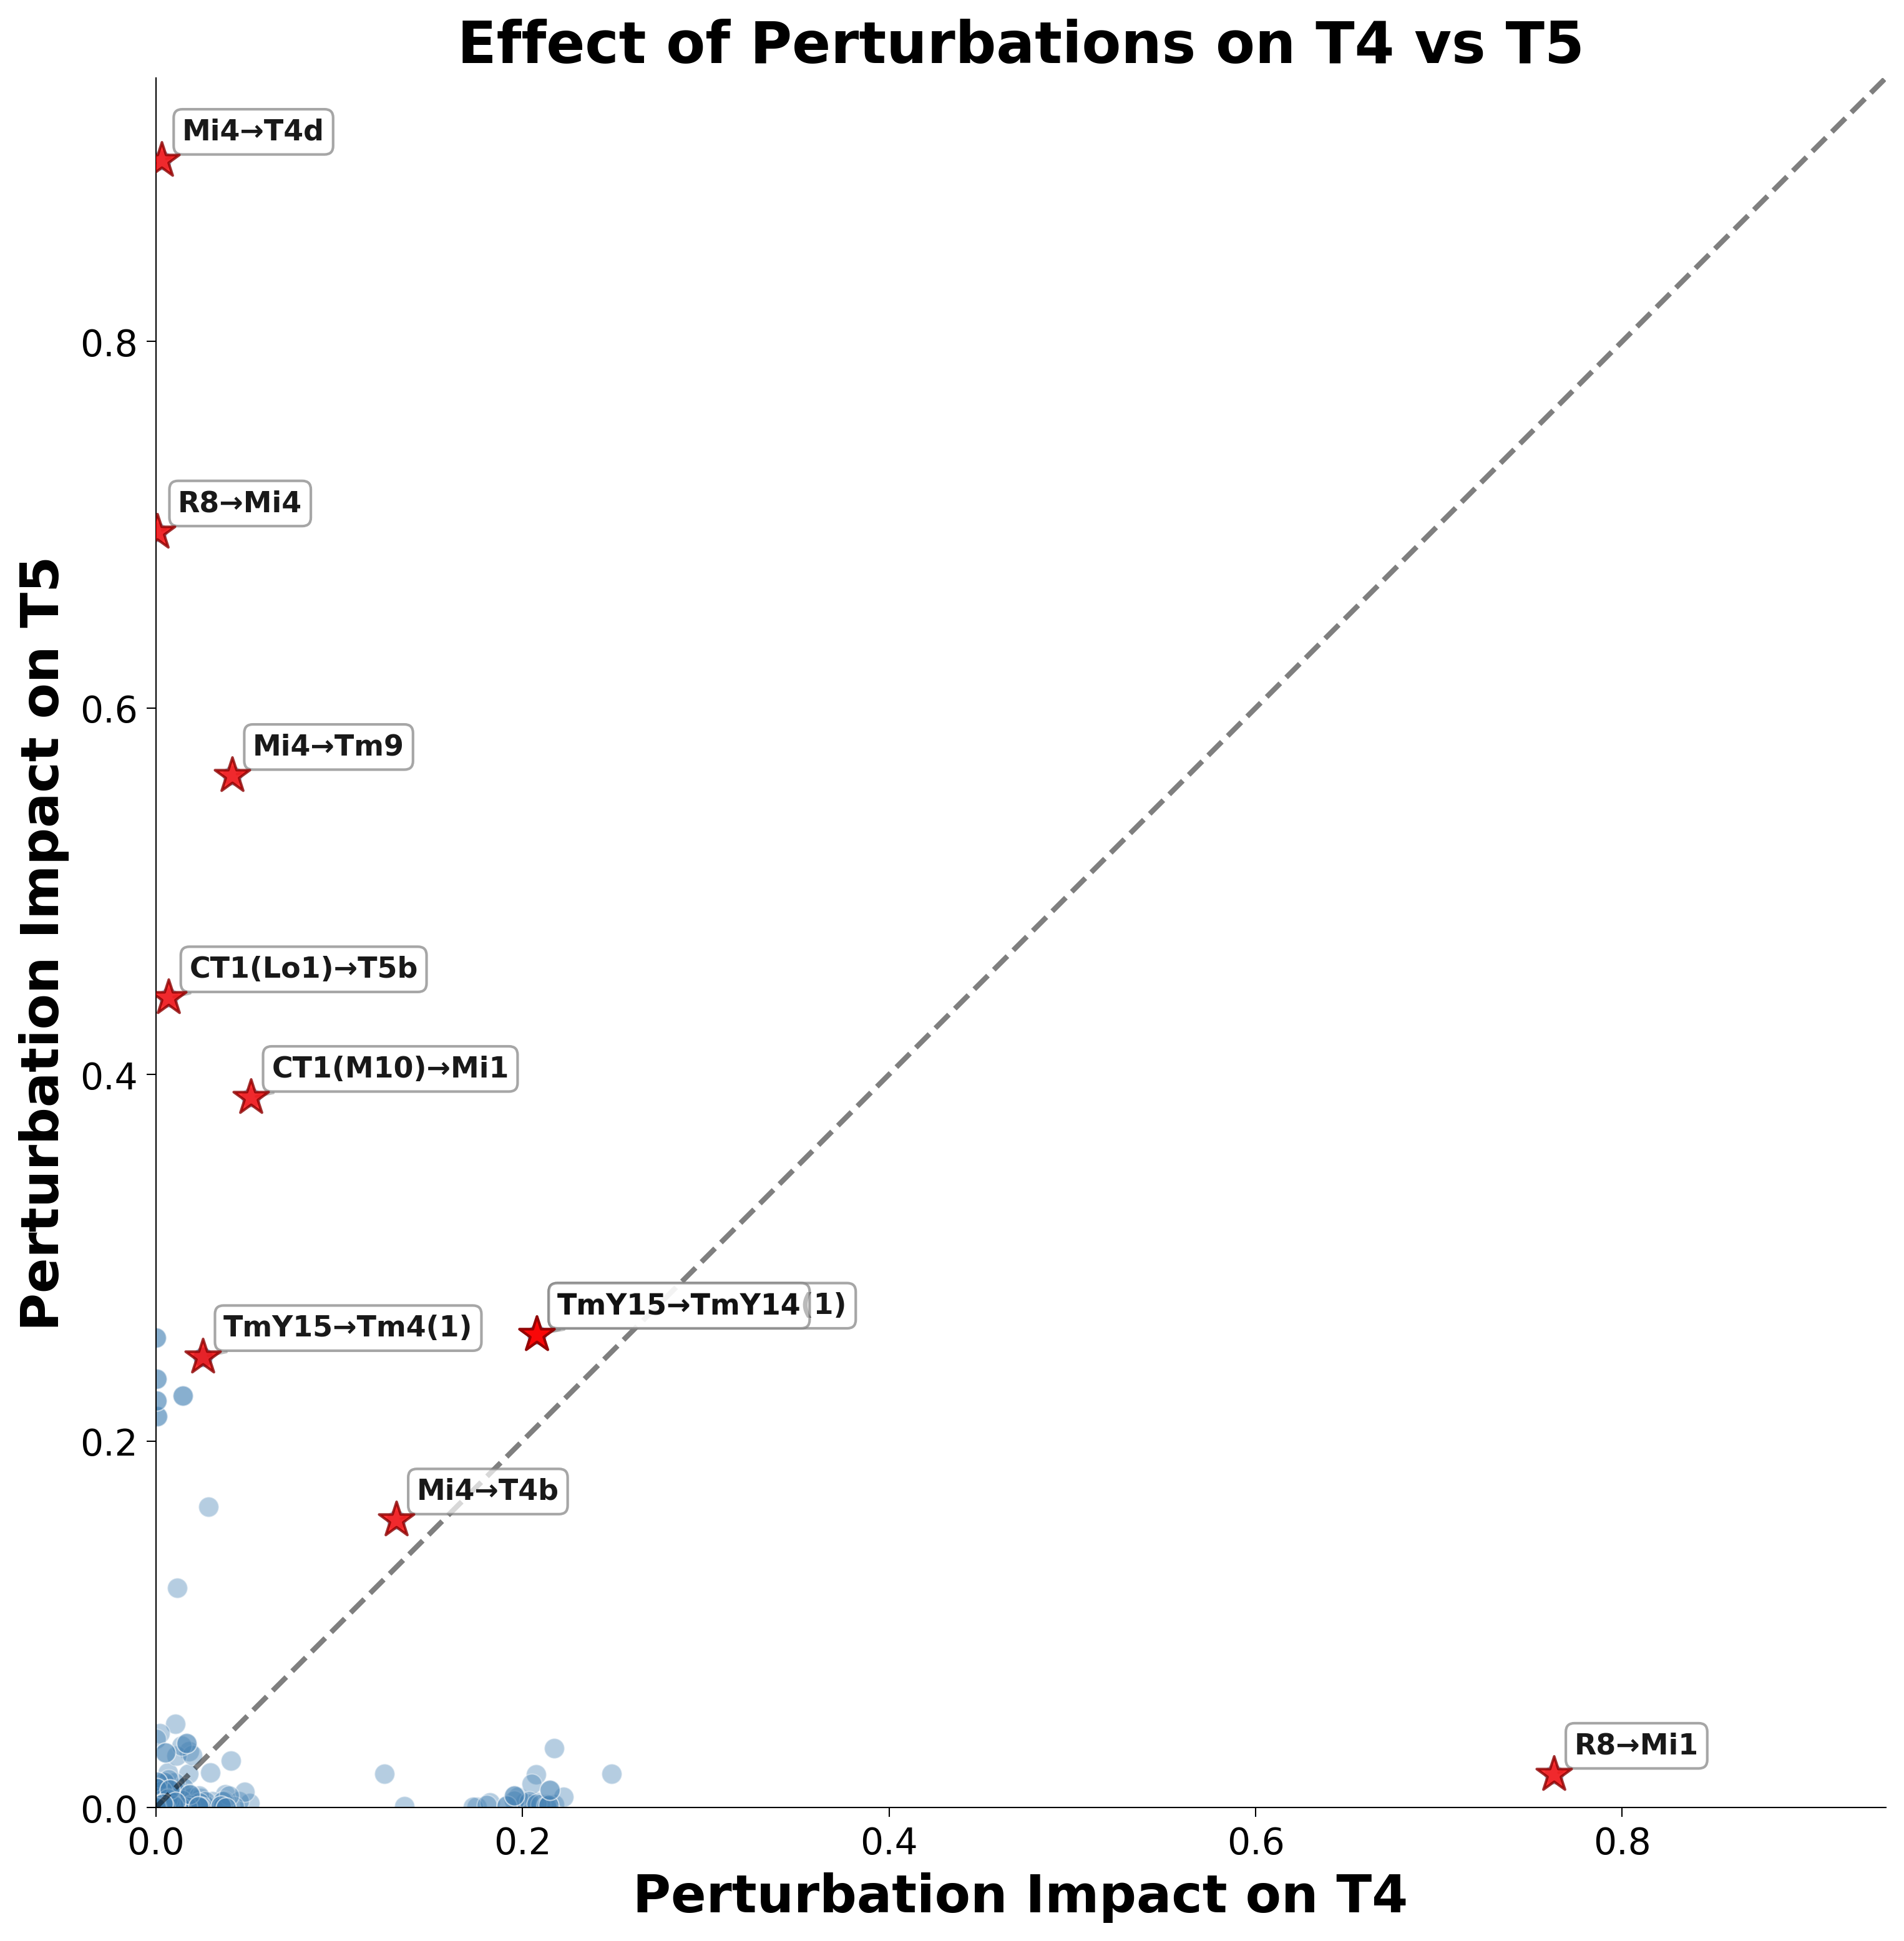

In [34]:
if __name__ == "__main__":
    # Load your results (assumes you've run the main analysis)
    output_dir = r"C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\analysis_outputs"
    
    # Load sensitivity data
    sensitivity_df = pd.read_csv(f"{output_dir}/all_perturbation_sensitivity.csv")
    
    # Load cell type aggregations
    t4_source_sens = pd.read_csv(f"{output_dir}/T4_source_sensitivity.csv", index_col=0)
    t4_target_sens = pd.read_csv(f"{output_dir}/T4_target_sensitivity.csv", index_col=0)
    t5_source_sens = pd.read_csv(f"{output_dir}/T5_source_sensitivity.csv", index_col=0)
    t5_target_sens = pd.read_csv(f"{output_dir}/T5_target_sensitivity.csv", index_col=0)
    
    # Generate improved plots
    plot_cell_type_sensitivity_bars(
        t4_source_sens, t4_target_sens, 'T4', top_n=25,
        output_path=f"{output_dir}/T4_celltype_sensitivity_improved.png"
    )
    
    plot_cell_type_sensitivity_bars(
        t5_source_sens, t5_target_sens, 'T5', top_n=25,
        output_path=f"{output_dir}/T5_celltype_sensitivity_improved.png"
    )
    
    plot_t4_vs_t5_sensitivity(
        sensitivity_df,
        output_path=f"{output_dir}/T4_vs_T5_sensitivity_improved.png"
    )
    
    # Optional: signed delta version
    #plot_t4_vs_t5_delta(
    #    sensitivity_df,
    #    output_path=f"{output_dir}/T4_vs_T5_delta.png"
    #)

In [ ]:
if __name__ == "__main__":
    results = run_full_analysis()